# Table Cutoff Experiment
1. 다중 이미지 기반 정보 추출
2. 병합 이미지 기반 정보 추출

In [1]:
import os
import json
import yaml
from pprint import pprint

from IPython.display import Image, display

from typing import TypedDict, Annotated, List, Dict, Tuple

from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.prompts import load_prompt

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
with open('../data/document/역도/documentParseGraph_state.json', 'r') as f:
    state = json.load(f)

class GraphState(TypedDict):
    filepath: Annotated[str, 'filepath']
    filepath_pdf: Annotated[str, 'pdf filepath']
    originData: Annotated[List[Dict], 'originData']
    documents: Annotated[List[Dict], 'documents']
    heading_structure: Annotated[List[str], 'heading structure. last heading is borderline']
    unused_elements: Annotated[List[Tuple[str, str]], 'unused elements']
    image_result: Annotated[List[Dict], 'result of image information extractor ']
    chart_result: Annotated[List[Dict], 'result of chart information extractor ']
    table_result: Annotated[List[Dict], 'result of table information extractor ']
    
state = GraphState(**state)

In [3]:
import base64

def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        image_content = image_file.read()
        file_ext = os.path.splitext(image_path)[1].lower()

        if file_ext in ['.jpg', '.jpeg']:
            mime_type = 'image/jpeg'
        elif file_ext == '.png':
            mime_type = 'image/png'
        else:
            mime_type = 'image/unknown'

        return base64.b64encode(image_content).decode("utf-8"), mime_type


In [4]:
def load_prompt(yaml_file):
    with open(yaml_file, "r", encoding="utf-8") as file:
        return yaml.safe_load(file)

In [5]:
def parse_json_string(json_str):
    try:
        return json.loads(json_str)
    except json.JSONDecodeError as e:
        print(f"JSON 파싱 에러: {e}")
        return None

In [6]:
path_dir = '../data/experiment/informationExtract/table/cutoff'
file_list = os.listdir(path_dir)

dataset = {}

dataset_key = sorted(set(['_'.join(file.split('_')[:2]) for file in file_list]))
for data in dataset_key:
    dataset[data] = [os.path.join(path_dir, file) for file in file_list if data in file]


## 다중 이미지 처리 기반 정보 추출

In [7]:
dataset

{'cutoff_1': ['../data/experiment/informationExtract/table/cutoff\\cutoff_1_1.png',
  '../data/experiment/informationExtract/table/cutoff\\cutoff_1_2.png'],
 'cutoff_2': ['../data/experiment/informationExtract/table/cutoff\\cutoff_2_1.png',
  '../data/experiment/informationExtract/table/cutoff\\cutoff_2_2.png',
  '../data/experiment/informationExtract/table/cutoff\\cutoff_2_3.png'],
 'cutoff_3': ['../data/experiment/informationExtract/table/cutoff\\cutoff_3_1.png',
  '../data/experiment/informationExtract/table/cutoff\\cutoff_3_2.png'],
 'cutoff_4': ['../data/experiment/informationExtract/table/cutoff\\cutoff_4_1.png',
  '../data/experiment/informationExtract/table/cutoff\\cutoff_4_2.png']}

### gpt-4o-mini

In [38]:
def draw_image_result(image_list, model_name='gpt-4o-mini'):
    prompt = load_prompt('../prompt/information_table/table_cutoff_20250304_01.yaml')

    for message in prompt['messages']:
        if message['role'] == 'user':
            for i, file in enumerate(image_list):
                if i > 0:
                    base64_image, image_type = encode_image(file)

                    message['content'].append({
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/{image_type};base64,{base64_image}"
                        }
                    })
            break

    chat_prompt = ChatPromptTemplate.from_messages(prompt['messages'])
    llm = ChatOpenAI(model=model_name, temperature=0)
    chain = chat_prompt | llm

    base64_image, image_type = encode_image(image_list[0])
    result = chain.invoke({'image_type': image_type,
                           'base64_image': base64_image,
                           'language': 'KOREAN'})

    for img_path in sorted(image_list):
        display(Image(img_path))
    
    print("\n\n--------------------------------\n\n")
    
    pprint(parse_json_string(result.content))

    print("\n\n--------------------------------\n\n")
    input_token = result.response_metadata['token_usage']['prompt_tokens']
    output_token = result.response_metadata['token_usage']['completion_tokens']

    input_dolor = round(input_token * 0.0001 * 0.15, 5)
    output_dolor = round(output_token * 0.0001 * 0.6, 5)

    input_won = round(input_dolor * 1440)
    output_won = round(output_dolor * 1440)

    print(f"input: {input_token},  {input_dolor}$, {input_won}원")
    print(f"output: {output_token},  {output_dolor}$, {output_won}원")
    return result

### gpt-4o-mini 모델

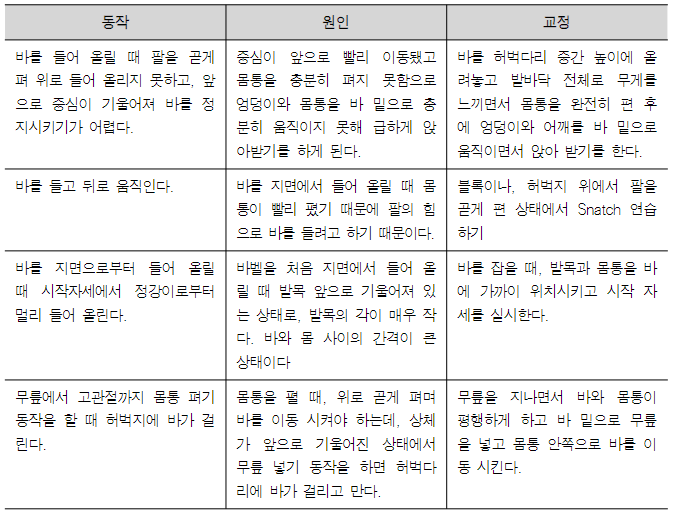

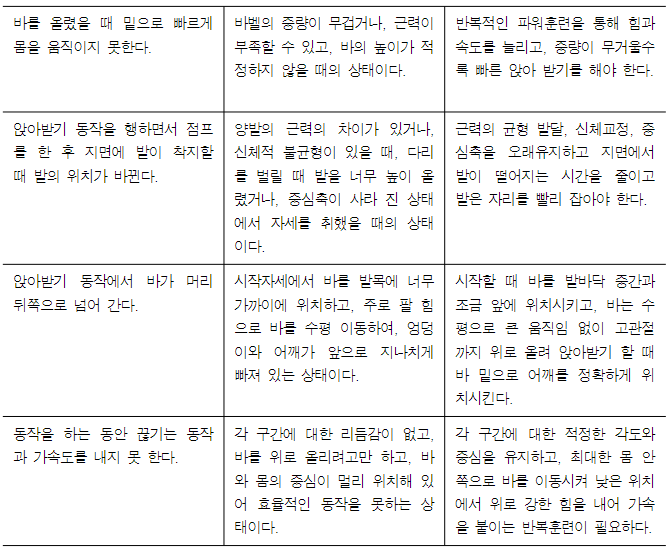



--------------------------------


{'table': {'headers': ['동작', '원인', '교정'], 'rows': [{'동작': '바를 들어 올릴 때 팔을 굽혀 위로 들어 올리지 못하고, 앞으로 중심이 기울어져 바를 정지시키기가 어렵다.', '원인': '중심이 앞으로 빨리 이동했고, 몸통이 충분히 펴지 못했으므로 영점이 움직이는 바 미로를 충분히 올리지 못하게 된다.', '교정': '바를 허리보다 중간 높이에 올려놓고 발바닥 전체로 무게를 느끼면서 바를 안정적으로 잡은 후 몸의 중심이 앞으로 나아가게 한다.'}, {'동작': '바를 들고 뒤로 움직인다.', '원인': '바를 지면으로부터 들어 올릴 때 몸통이 빨리 젖기 때문에 팔이 힘으로 바를 들고 하게 때문이다.', '교정': '블록을 이용해 허리와 위에서 팔을 굽혀 전 상태에서 Snatch 연습하기.'}, {'동작': '바를 지면으로부터 들어 올릴 때 시작자세에서 정강이로부터 멀리 들어 올린다.', '원인': '바벨을 처음 지면에서 들어 올릴 때 발의 앞쪽을 기준으로 해서 있는 상태로, 발목과 무릎이 저지대에 있다. 바벨과 몸 사이의 간격은 고상해야 한다.', '교정': '바를 잡은 뒤 발목과 몸통을 바에 가까이 위치시키고 시작자세를 실시한다.'}, {'동작': '무릎까지 고관절까지 몸통을 펴기 동작을 할 때 허리와 바가 걸린다.', '원인': '몸통을 펴고 위로 굽게 펴면 바를 이리저리 흔들리게 하여 무릎 높이 동작을 하게 하더라도 바가 걸리곤 만다.', '교정': '몸을 지나면서 바와 몸통이 평행하게 하여 바를 몸의 중심으로 학습하도록 한다.'}, {'동작': '바를 올렸을 때 믿음으로 빠르게 몸을 움직이지 못한다.', '원인': '바벨의 중량이 무겁거나, 근력이 부족할 수 있고, 바의 높이가 적정하지 않을 때의 상태이다.', '교정': '반복적인 피로훈련을 통해 힘과 속도를 늘리고, 중심이 무거울수록 바를 안아 반기를 해야 한다.'}, {'동작': '앞아래기 동

AIMessage(content='{\n  "table": {\n    "headers": ["동작", "원인", "교정"],\n    "rows": [\n      {\n        "동작": "바를 들어 올릴 때 팔을 굽혀 위로 들어 올리지 못하고, 앞으로 중심이 기울어져 바를 정지시키기가 어렵다.",\n        "원인": "중심이 앞으로 빨리 이동했고, 몸통이 충분히 펴지 못했으므로 영점이 움직이는 바 미로를 충분히 올리지 못하게 된다.",\n        "교정": "바를 허리보다 중간 높이에 올려놓고 발바닥 전체로 무게를 느끼면서 바를 안정적으로 잡은 후 몸의 중심이 앞으로 나아가게 한다."\n      },\n      {\n        "동작": "바를 들고 뒤로 움직인다.",\n        "원인": "바를 지면으로부터 들어 올릴 때 몸통이 빨리 젖기 때문에 팔이 힘으로 바를 들고 하게 때문이다.",\n        "교정": "블록을 이용해 허리와 위에서 팔을 굽혀 전 상태에서 Snatch 연습하기."\n      },\n      {\n        "동작": "바를 지면으로부터 들어 올릴 때 시작자세에서 정강이로부터 멀리 들어 올린다.",\n        "원인": "바벨을 처음 지면에서 들어 올릴 때 발의 앞쪽을 기준으로 해서 있는 상태로, 발목과 무릎이 저지대에 있다. 바벨과 몸 사이의 간격은 고상해야 한다.",\n        "교정": "바를 잡은 뒤 발목과 몸통을 바에 가까이 위치시키고 시작자세를 실시한다."\n      },\n      {\n        "동작": "무릎까지 고관절까지 몸통을 펴기 동작을 할 때 허리와 바가 걸린다.",\n        "원인": "몸통을 펴고 위로 굽게 펴면 바를 이리저리 흔들리게 하여 무릎 높이 동작을 하게 하더라도 바가 걸리곤 만다.",\n        "교정": "몸을 지나면서 바와 몸통이 평행하게 하여 바를 몸의 중심으로 학습하도록 한다."\n      },\n      {\

In [ ]:
result_noProcessing_1 = draw_image_result(dataset['cutoff_1'])

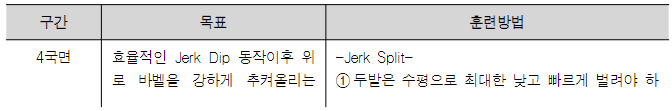

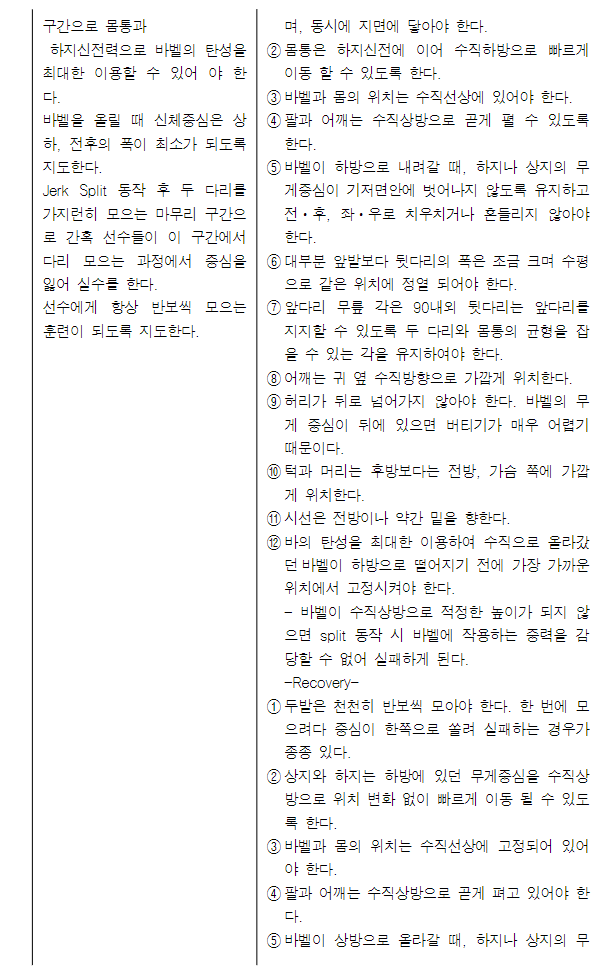

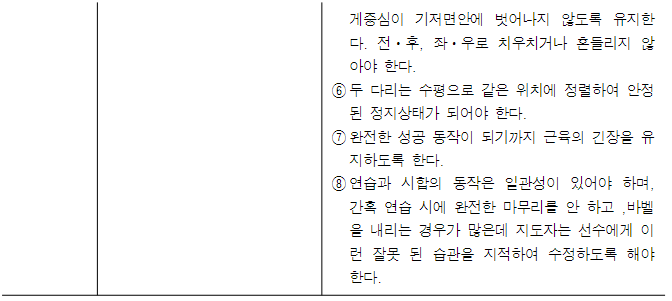



--------------------------------


{'테이블': {'구간': '4극면', '목표': '효율적인 Jerk Dip 동작 이후 위로 바벨을 강하게 추켜올리는', '훈련방법': [{'방법': '-Jerk Split-', '설명': '① 두 발은 수형으로 최대한 낮고 빠르게 벌려야 하며, 동시에 지면에 달아야 한다.'}, {'방법': '', '설명': '② 롱폼은 하지신전에서 이어 수직방향으로 빠르게 이동할 수 있도록 한다.'}, {'방법': '', '설명': '③ 바벨과 몸의 위치는 수직선상에 있어야 한다.'}, {'방법': '', '설명': '④ 팔과 어깨는 수직상방으로 곧게 펴고 있어야 한다.'}, {'방법': '', '설명': '⑤ 바벨이 하방으로 내려갈 때, 하지가 상체의 균형을 유지하지 않도록 하여야 한다.'}, {'방법': '', '설명': '⑥ 두 다리는 수평으로 같은 위치에 정렬하여 안정된 정지상태가 되어야 한다.'}, {'방법': '', '설명': '⑦ 완전한 성공 동작이 되기까지 근육의 긴장을 유지하도록 한다.'}, {'방법': '', '설명': '⑧ 연습과 시합의 동작은 일관성이 있어야 하며, 간혹 연습 시에 원치한 마무리를 하고, 바벨은 내리는 경우가 많으면 지도자는 선수가 이런 잘못된 습관을 지적하도록 해야 한다.'}]}}


--------------------------------


input: 1895,  0.02842$, 41원
output: 407,  0.02442$, 35원


AIMessage(content='{\n  "테이블": {\n    "구간": "4극면",\n    "목표": "효율적인 Jerk Dip 동작 이후 위로 바벨을 강하게 추켜올리는",\n    "훈련방법": [\n      {\n        "방법": "-Jerk Split-",\n        "설명": "① 두 발은 수형으로 최대한 낮고 빠르게 벌려야 하며, 동시에 지면에 달아야 한다."\n      },\n      {\n        "방법": "",\n        "설명": "② 롱폼은 하지신전에서 이어 수직방향으로 빠르게 이동할 수 있도록 한다."\n      },\n      {\n        "방법": "",\n        "설명": "③ 바벨과 몸의 위치는 수직선상에 있어야 한다."\n      },\n      {\n        "방법": "",\n        "설명": "④ 팔과 어깨는 수직상방으로 곧게 펴고 있어야 한다."\n      },\n      {\n        "방법": "",\n        "설명": "⑤ 바벨이 하방으로 내려갈 때, 하지가 상체의 균형을 유지하지 않도록 하여야 한다."\n      },\n      {\n        "방법": "",\n        "설명": "⑥ 두 다리는 수평으로 같은 위치에 정렬하여 안정된 정지상태가 되어야 한다."\n      },\n      {\n        "방법": "",\n        "설명": "⑦ 완전한 성공 동작이 되기까지 근육의 긴장을 유지하도록 한다."\n      },\n      {\n        "방법": "",\n        "설명": "⑧ 연습과 시합의 동작은 일관성이 있어야 하며, 간혹 연습 시에 원치한 마무리를 하고, 바벨은 내리는 경우가 많으면 지도자는 선수가 이런 잘못된 습관을 지적하도록 해야 한다."\n      }\n    ]\n  }\n}', additional_kwargs={'refusal': None}, response_

In [32]:
result_noProcessing_2 = draw_image_result(dataset['cutoff_2'])

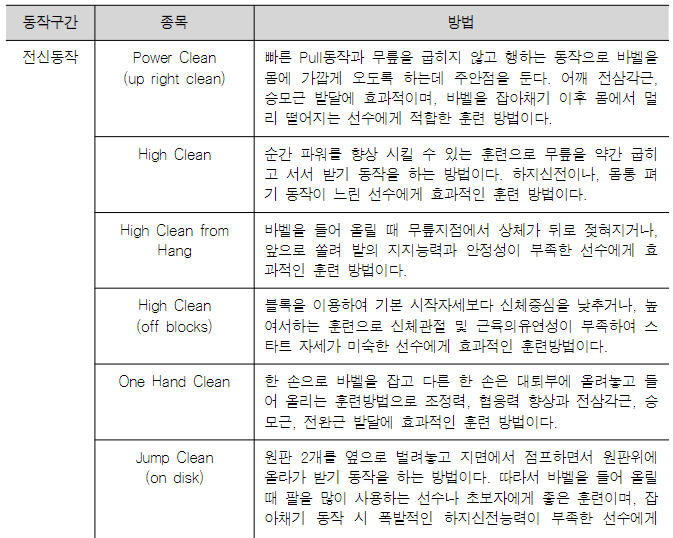

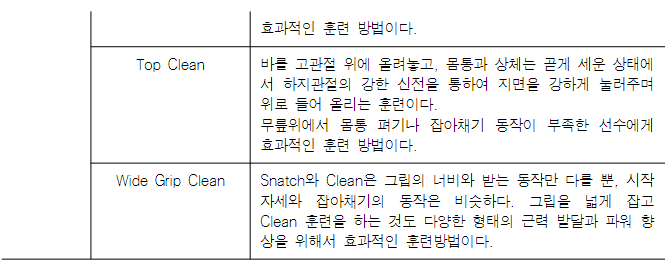



--------------------------------


{'전신동작': [{'방법': '빠른 Pull동작과 무릎을 급히 일지 않고 행하는 동작으로 바벨을 몸에 가까이 오도록 하는 데 주안점을 '
                 '둔다. 어깨 전사각도, 승모근 발달이 효과적이며, 바벨을 잡아주기 이후 몸에 멀리 떨어져 있는 선수에게 '
                 '적합한 훈련 방법이다.',
           '종목': 'Power Clean (up right clean)'},
          {'방법': '순간 파워를 항상 시킬 수 있는 훈련으로 무릎을 약간 굽히고 서서 반기 동작을 하는 방법이다. 하지만 '
                 '전신이, 몸통 편기 동작이 느린 선수에게 효과적인 훈련 방법이다.',
           '종목': 'High Clean'},
          {'방법': '바벨을 들어 올릴 때 무릎지점에서 상체를 뒤로 젖히거나, 앞쪽을 쳐다보며 지지능력과 안정성의 부족한 선수에게 '
                 '효과적인 훈련 방법이다.',
           '종목': 'High Clean from Hang'},
          {'방법': '블록을 이용하여 기존 시작자세에서 체중을 낮추거나, 높여서 하는 훈련은 신체관절 및 근육의 안정성에 부족하여 '
                 '스타 자세에서 미숙한 선수에게 효과적인 훈련방법이다.',
           '종목': 'High Clean (off blocks)'},
          {'방법': '한 손으로 바벨을 잡고 들 수 있는 대체적인 훈련으로 들 어 올리는 훈련방법을 조정하는 방법이다. 모른, '
                 '결과적으로 효과적인 훈련 방법이다.',
           '종목': 'One Hand Clean'},
          {'방법': '원판 2개를 바벨로 분리하는 지점에서 접어져서 원판이 올라가 반기 동작을 하는 방법이다. 따라

AIMessage(content='{\n  "전신동작": [\n    {\n      "종목": "Power Clean (up right clean)",\n      "방법": "빠른 Pull동작과 무릎을 급히 일지 않고 행하는 동작으로 바벨을 몸에 가까이 오도록 하는 데 주안점을 둔다. 어깨 전사각도, 승모근 발달이 효과적이며, 바벨을 잡아주기 이후 몸에 멀리 떨어져 있는 선수에게 적합한 훈련 방법이다."\n    },\n    {\n      "종목": "High Clean",\n      "방법": "순간 파워를 항상 시킬 수 있는 훈련으로 무릎을 약간 굽히고 서서 반기 동작을 하는 방법이다. 하지만 전신이, 몸통 편기 동작이 느린 선수에게 효과적인 훈련 방법이다."\n    },\n    {\n      "종목": "High Clean from Hang",\n      "방법": "바벨을 들어 올릴 때 무릎지점에서 상체를 뒤로 젖히거나, 앞쪽을 쳐다보며 지지능력과 안정성의 부족한 선수에게 효과적인 훈련 방법이다."\n    },\n    {\n      "종목": "High Clean (off blocks)",\n      "방법": "블록을 이용하여 기존 시작자세에서 체중을 낮추거나, 높여서 하는 훈련은 신체관절 및 근육의 안정성에 부족하여 스타 자세에서 미숙한 선수에게 효과적인 훈련방법이다."\n    },\n    {\n      "종목": "One Hand Clean",\n      "방법": "한 손으로 바벨을 잡고 들 수 있는 대체적인 훈련으로 들 어 올리는 훈련방법을 조정하는 방법이다. 모른, 결과적으로 효과적인 훈련 방법이다."\n    },\n    {\n      "종목": "Jump Clean (on disk)",\n      "방법": "원판 2개를 바벨로 분리하는 지점에서 접어져서 원판이 올라가 반기 동작을 하는 방법이다. 따라서 원판을 들고 있을 때 팔을 많이 사용하는 것도 다양한 형태의 근력 발달과 파워 향상을 위해서 효과적인

In [36]:
draw_image_result(dataset['cutoff_3'])

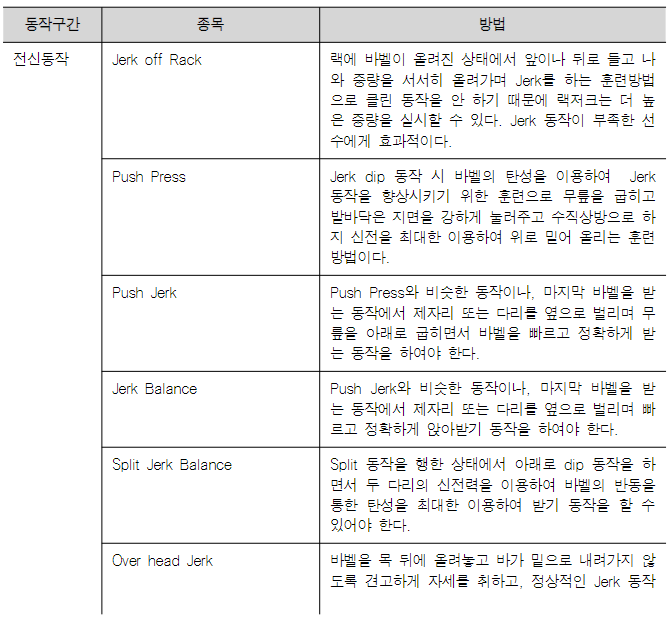

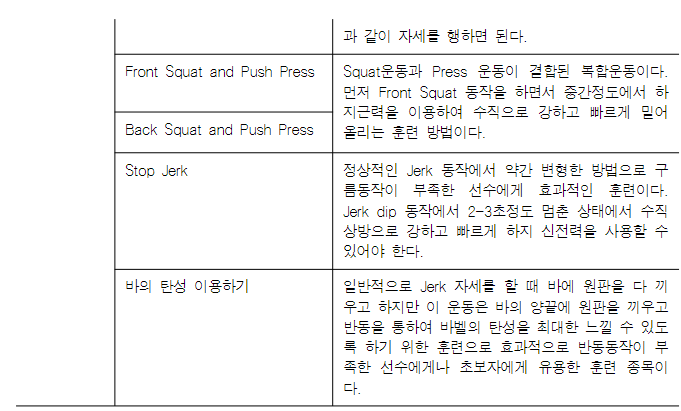



--------------------------------


{'운동종목': [{'동작구간': '전신동작',
           '방법': '랙에 바벨이 올려진 상태에서 앞이나 뒤로 들고 나와 종목을 서서히 올리며 Jerk를 하는 훈련방법으로 클린 '
                 '동작은 안 하기 때문에 랙에서는 높은 종목을 실시할 수 있다. Jerk 동작이 부착한 선수에게 효과적이다.',
           '종목': 'Jerk off Rack'},
          {'동작구간': '전신동작',
           '방법': 'Jerk dip 동작 시 바벨의 탄성을 이용하여 Jerk 동작을 향상시키기 위한 훈련으로 무릎을 굽히고 '
                 '발바닥은 지면을 강하게 눌러주고 주시상하로 하지 신전을 최대한 이용하여 위로 밀어 올리는 훈련 방법이다.',
           '종목': 'Push Press'},
          {'동작구간': '전신동작',
           '방법': 'Push Press와 비슷한 동작이나, 마지막 바벨을 받는 동작에서 지지대 또는 다리를 엮으려면 무릎을 '
                 '아래로 굽히면서 바벨을 받고 정착하지 않아야 하는 동작을 하여야 한다.',
           '종목': 'Push Jerk'},
          {'동작구간': '전신동작',
           '방법': 'Jerk Jerk와 비슷한 동작이나, 마지막 바벨을 받는 동작에서 지지대 또는 다리를 엮으려면 빠르고 '
                 '정착하지 않아야 하는 동작을 하여야 한다.',
           '종목': 'Jerk Balance'},
          {'동작구간': '전신동작',
           '방법': 'Split 동작을 행한 상태에서 아래로 동작을 하면서 두 다리의 신전력을 최대한 이용하여 바벨을 들고 자세를 '
                 '취해야 하며, 정상적인 Jerk 동작을

AIMessage(content='{\n  "운동종목": [\n    {\n      "동작구간": "전신동작",\n      "종목": "Jerk off Rack",\n      "방법": "랙에 바벨이 올려진 상태에서 앞이나 뒤로 들고 나와 종목을 서서히 올리며 Jerk를 하는 훈련방법으로 클린 동작은 안 하기 때문에 랙에서는 높은 종목을 실시할 수 있다. Jerk 동작이 부착한 선수에게 효과적이다."\n    },\n    {\n      "동작구간": "전신동작",\n      "종목": "Push Press",\n      "방법": "Jerk dip 동작 시 바벨의 탄성을 이용하여 Jerk 동작을 향상시키기 위한 훈련으로 무릎을 굽히고 발바닥은 지면을 강하게 눌러주고 주시상하로 하지 신전을 최대한 이용하여 위로 밀어 올리는 훈련 방법이다."\n    },\n    {\n      "동작구간": "전신동작",\n      "종목": "Push Jerk",\n      "방법": "Push Press와 비슷한 동작이나, 마지막 바벨을 받는 동작에서 지지대 또는 다리를 엮으려면 무릎을 아래로 굽히면서 바벨을 받고 정착하지 않아야 하는 동작을 하여야 한다."\n    },\n    {\n      "동작구간": "전신동작",\n      "종목": "Jerk Balance",\n      "방법": "Jerk Jerk와 비슷한 동작이나, 마지막 바벨을 받는 동작에서 지지대 또는 다리를 엮으려면 빠르고 정착하지 않아야 하는 동작을 하여야 한다."\n    },\n    {\n      "동작구간": "전신동작",\n      "종목": "Split Jerk Balance",\n      "방법": "Split 동작을 행한 상태에서 아래로 동작을 하면서 두 다리의 신전력을 최대한 이용하여 바벨을 들고 자세를 취해야 하며, 정상적인 Jerk 동작을 할 수 있다."\n    },\n    {\n      "동작구간": "전신동작",\n      "종목": "Ove

In [37]:
draw_image_result(dataset['cutoff_4'])

### gpt-40 모델

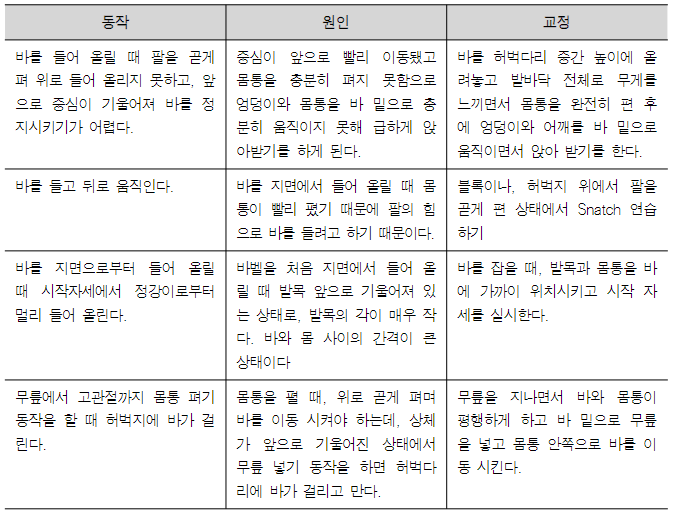

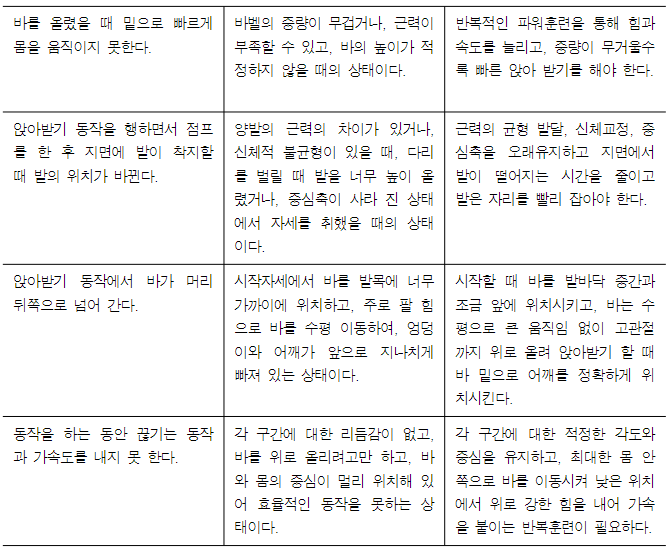



--------------------------------


{'table': [{'교정': '바를 허벅다리 중간 높이에 올려놓고 반박치 전체로 무게를 느끼면서 몸통을 완전히 편 후 바를 잡으면서 '
                  '어깨를 바 밑으로 움직이면서 앉아 받기를 한다.',
            '동작': '바를 들어 올릴 때 팔을 굽게 펴 위로 들어 올리지 못하고, 앞으로 중심이 기울어져 바를 정지시키기가 '
                  '어렵다.',
            '원인': '중심이 앞으로 빨리 이동했고 몸통을 충분히 펴지 못했으므로 엉덩이와 몸통을 바 밑으로 충분히 움직이지 못해 '
                  '급하게 앞 아닌가를 하게 된다.'},
           {'교정': '블록을 이용, 허벅지 위에서 팔을 굽게 전 상태에서 Snatch 연습하기',
            '동작': '바를 들고 뒤로 움직인다.',
            '원인': '바를 지면에서 들어 올릴 때 몸통이 빨리 펴지기 때문에 팔의 힘으로 바를 들어올리기 때문이다.'},
           {'교정': '바를 잡을 때, 발목과 몸통을 바에 가까이 위치시키고 시작 자세를 실시한다.',
            '동작': '바를 지면으로부터 들어 올릴 때 시작자세에서 정강이로부터 멀리 들어 올린다.',
            '원인': '바벨을 처음 지면에서 들어 올릴 때 발을 앞으로 기울어져 있는 상태로, 발목의 각이 매우 작다. 바와 몸 '
                  '사이의 간격이 큰 상태이다.'},
           {'교정': '몸통을 지나면서 바와 몸통이 평행하게 하고 바 밑으로 무릎을 넣고 몸을 완전히 펴는 동작 시킨다.',
            '동작': '무릎에서 고관절까지 몸통 펴기 동작을 할 때 허벅지에 바가 걸린다.',
            '원인': '몸통을 펴며, 위로 굽게 펴며 바를 이동 시키려 하며, 상체가 앞으로 

AIMessage(content='{\n  "table": [\n    {\n      "동작": "바를 들어 올릴 때 팔을 굽게 펴 위로 들어 올리지 못하고, 앞으로 중심이 기울어져 바를 정지시키기가 어렵다.",\n      "원인": "중심이 앞으로 빨리 이동했고 몸통을 충분히 펴지 못했으므로 엉덩이와 몸통을 바 밑으로 충분히 움직이지 못해 급하게 앞 아닌가를 하게 된다.",\n      "교정": "바를 허벅다리 중간 높이에 올려놓고 반박치 전체로 무게를 느끼면서 몸통을 완전히 편 후 바를 잡으면서 어깨를 바 밑으로 움직이면서 앉아 받기를 한다."\n    },\n    {\n      "동작": "바를 들고 뒤로 움직인다.",\n      "원인": "바를 지면에서 들어 올릴 때 몸통이 빨리 펴지기 때문에 팔의 힘으로 바를 들어올리기 때문이다.",\n      "교정": "블록을 이용, 허벅지 위에서 팔을 굽게 전 상태에서 Snatch 연습하기"\n    },\n    {\n      "동작": "바를 지면으로부터 들어 올릴 때 시작자세에서 정강이로부터 멀리 들어 올린다.",\n      "원인": "바벨을 처음 지면에서 들어 올릴 때 발을 앞으로 기울어져 있는 상태로, 발목의 각이 매우 작다. 바와 몸 사이의 간격이 큰 상태이다.",\n      "교정": "바를 잡을 때, 발목과 몸통을 바에 가까이 위치시키고 시작 자세를 실시한다."\n    },\n    {\n      "동작": "무릎에서 고관절까지 몸통 펴기 동작을 할 때 허벅지에 바가 걸린다.",\n      "원인": "몸통을 펴며, 위로 굽게 펴며 바를 이동 시키려 하며, 상체가 앞으로 기울어져 있는 상태에서 무릎 넣기 동작을 하려 하다 바리에 바가 걸리고 만다.",\n      "교정": "몸통을 지나면서 바와 몸통이 평행하게 하고 바 밑으로 무릎을 넣고 몸을 완전히 펴는 동작 시킨다."\n    },\n    {\n      "동작": "바를 올렸을 때 밑으로 빠르게 몸을 움직이지 못

In [40]:
draw_image_result(dataset['cutoff_1'], model_name='gpt-4o')

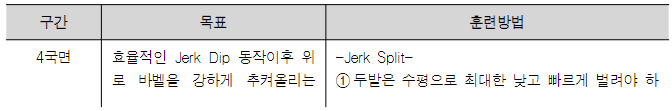

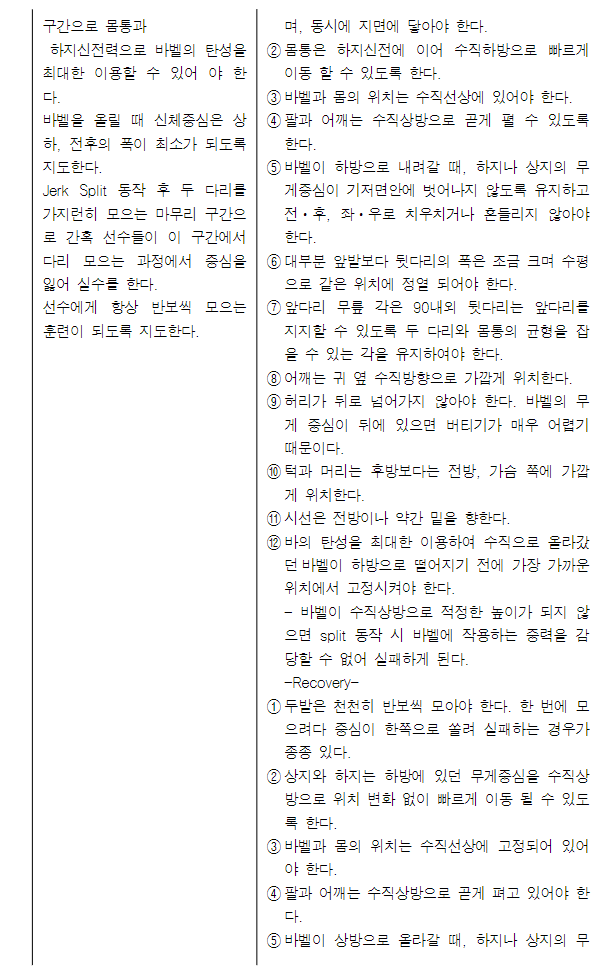

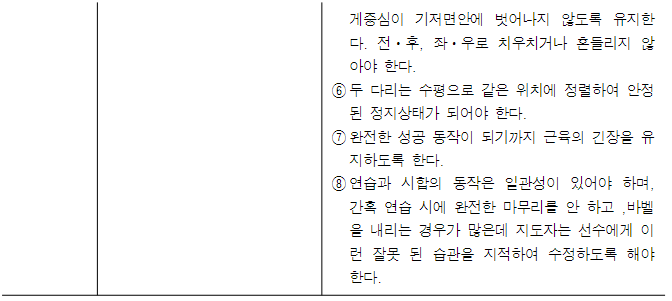



--------------------------------


{'구간': '4극면',
 '목표': '효율적인 Jerk Dip 동작이후 위로 바벨을 강하게 추켜올리는',
 '훈련방법': ['-Jerk Split-',
          '① 두발은 수평으로 최대한 낮고 빠르게 벌려야 하며, 동시에 지면에 닿아야 한다.',
          '② 몸통은 하지신전에 이어 수직하방으로 빠르게 이동 할 수 있도록 한다.',
          '③ 바벨과 몸의 위치는 수직선상에 있어야 한다.',
          '④ 팔과 어깨는 수직방향으로 곧게 펼 수 있도록 한다.',
          '⑤ 바벨이 하방으로 내려갈 때, 하지나 상지의 무게중심이 앞뒤로 치우치거나 혼란되지 않아야 한다.',
          '⑥ 대부분의 체중이 뒷다리에 걸쳐 있는 것을 크게 수정하여 안정된 정지상태가 되어야 한다.',
          '⑦ 앞다리 무릎 각은 90도의 뒷다리는 무릎이 지지할 수 있도록 두 다리의 몸통의 균형을 잡을 수 있는 위치에 있어야 '
          '한다.',
          '⑧ 어깨는 앞선 수직방향으로 위치해야 한다.',
          '⑨ 허리가 뒤로 넘어가지 않아야 한다. 바벨의 무게중심이 앞뒤로 치우치거나 혼란되지 않아야 한다.',
          '⑩ 턱과 머리는 후방보다는 전방, 가슴 쪽에 가깝게 위치한다.',
          '⑪ 시선은 전방이나 약간 밑을 향한다.',
          '⑫ 바의 탄성을 최대한 이용하여 수직으로 올리려던 바벨이 하방으로 떨어지기 전에 가장 가까운 위치에서 정점시켜야 한다.',
          '- 바벨이 수직상방으로 적정한 높이가 되지 않으면 split 동작 시 바벨에 작용하는 중력을 감당할 수 없어 실패하게 '
          '된다.',
          '-Recovery-',
          '① 두발은 천천히 반복씩 모아야 한다. 한 번에 모으려다 중심이 한쪽으로 쏠려 실패하는 경우가

AIMessage(content='{\n  "구간": "4극면",\n  "목표": "효율적인 Jerk Dip 동작이후 위로 바벨을 강하게 추켜올리는",\n  "훈련방법": [\n    "-Jerk Split-",\n    "① 두발은 수평으로 최대한 낮고 빠르게 벌려야 하며, 동시에 지면에 닿아야 한다.",\n    "② 몸통은 하지신전에 이어 수직하방으로 빠르게 이동 할 수 있도록 한다.",\n    "③ 바벨과 몸의 위치는 수직선상에 있어야 한다.",\n    "④ 팔과 어깨는 수직방향으로 곧게 펼 수 있도록 한다.",\n    "⑤ 바벨이 하방으로 내려갈 때, 하지나 상지의 무게중심이 앞뒤로 치우치거나 혼란되지 않아야 한다.",\n    "⑥ 대부분의 체중이 뒷다리에 걸쳐 있는 것을 크게 수정하여 안정된 정지상태가 되어야 한다.",\n    "⑦ 앞다리 무릎 각은 90도의 뒷다리는 무릎이 지지할 수 있도록 두 다리의 몸통의 균형을 잡을 수 있는 위치에 있어야 한다.",\n    "⑧ 어깨는 앞선 수직방향으로 위치해야 한다.",\n    "⑨ 허리가 뒤로 넘어가지 않아야 한다. 바벨의 무게중심이 앞뒤로 치우치거나 혼란되지 않아야 한다.",\n    "⑩ 턱과 머리는 후방보다는 전방, 가슴 쪽에 가깝게 위치한다.",\n    "⑪ 시선은 전방이나 약간 밑을 향한다.",\n    "⑫ 바의 탄성을 최대한 이용하여 수직으로 올리려던 바벨이 하방으로 떨어지기 전에 가장 가까운 위치에서 정점시켜야 한다.",\n    "- 바벨이 수직상방으로 적정한 높이가 되지 않으면 split 동작 시 바벨에 작용하는 중력을 감당할 수 없어 실패하게 된다.",\n    "-Recovery-",\n    "① 두발은 천천히 반복씩 모아야 한다. 한 번에 모으려다 중심이 한쪽으로 쏠려 실패하는 경우가 종종 있다.",\n    "② 상지와 하지는 하방에 있던 무게중심을 수직상방으로 위치 변화 없이 빠르게 이동 될 수 있도록 한다.",\n    "③ 바벨과 몸의 위치는 수직선상에 고정되어

In [41]:
draw_image_result(dataset['cutoff_2'], model_name='gpt-4o')

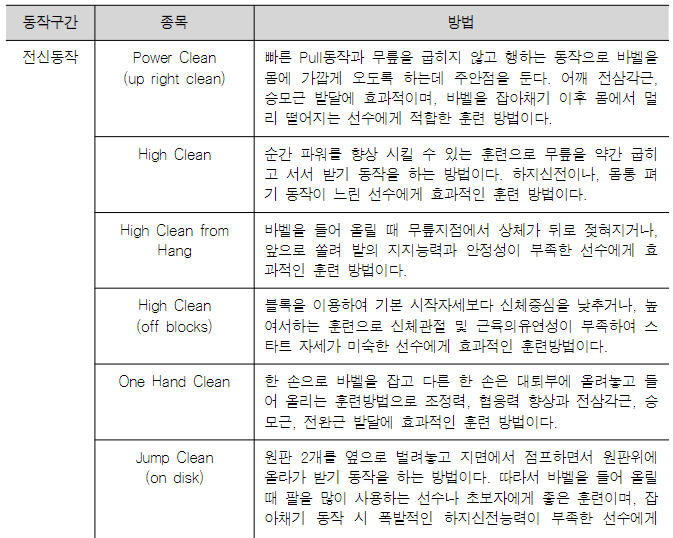

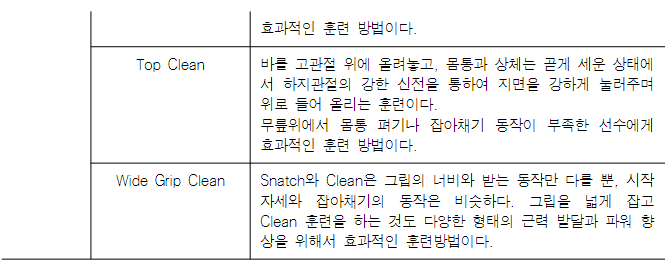



--------------------------------


{'동작구간': '전신동작',
 '종목': [{'방법': '빠른 Pull동작과 무릎을 굽히지 않고 행하는 동작으로 바벨을 몸에 가깝게 오도록 하여 주안점을 둔다. 어깨 '
               '전상각근, 승모근 발달에 효과적이며, 바벨을 잡아채기 이후 몸에서 멀리 떨어지는 선수에게 적합한 훈련 방법이다.',
         '이름': 'Power Clean (up right clean)'},
        {'방법': '순간 파워를 항상 시킬 수 있는 훈련으로 무릎을 약간 굽히고 서서 받기 동작을 하는 방법이다. 하지신전이나, '
               '통증 퍼지기 동작이 느린 선수에게 효과적인 훈련 방법이다.',
         '이름': 'High Clean'},
        {'방법': '바벨을 들어 올릴 때 무릎지점에서 상체가 뒤로 젖혀지거나, 앞으로 쏠려 받기 지지능력과 안정성이 부족한 선수에게 '
               '효과적인 훈련 방법이다.',
         '이름': 'High Clean from Hang'},
        {'방법': '블록을 이용하여 기본 시작자세보다 신체중심을 낮추거나, 높여서하는 훈련은 신체관절 및 근육의 안정성이 부족하여 '
               '스타트 자세가 미숙한 선수에게 효과적인 훈련방법이다.',
         '이름': 'High Clean (off blocks)'},
        {'방법': '한 손으로 바벨을 잡고 다른 손은 대퇴부에 올려놓고 들어 올리는 훈련방법으로 조정력, 균형성, 협응성, '
               '전신강화, 근모근, 전완 발달에 효과적인 훈련 방법이다.',
         '이름': 'One Hand Clean'},
        {'방법': '원판 2개를 발끝을 벌려놓는 지면에서 점프하면서 원판위에 올라가 받기 동작을 하는 방법이다. 따라서 발을 '
               '올

AIMessage(content='{\n  "동작구간": "전신동작",\n  "종목": [\n    {\n      "이름": "Power Clean (up right clean)",\n      "방법": "빠른 Pull동작과 무릎을 굽히지 않고 행하는 동작으로 바벨을 몸에 가깝게 오도록 하여 주안점을 둔다. 어깨 전상각근, 승모근 발달에 효과적이며, 바벨을 잡아채기 이후 몸에서 멀리 떨어지는 선수에게 적합한 훈련 방법이다."\n    },\n    {\n      "이름": "High Clean",\n      "방법": "순간 파워를 항상 시킬 수 있는 훈련으로 무릎을 약간 굽히고 서서 받기 동작을 하는 방법이다. 하지신전이나, 통증 퍼지기 동작이 느린 선수에게 효과적인 훈련 방법이다."\n    },\n    {\n      "이름": "High Clean from Hang",\n      "방법": "바벨을 들어 올릴 때 무릎지점에서 상체가 뒤로 젖혀지거나, 앞으로 쏠려 받기 지지능력과 안정성이 부족한 선수에게 효과적인 훈련 방법이다."\n    },\n    {\n      "이름": "High Clean (off blocks)",\n      "방법": "블록을 이용하여 기본 시작자세보다 신체중심을 낮추거나, 높여서하는 훈련은 신체관절 및 근육의 안정성이 부족하여 스타트 자세가 미숙한 선수에게 효과적인 훈련방법이다."\n    },\n    {\n      "이름": "One Hand Clean",\n      "방법": "한 손으로 바벨을 잡고 다른 손은 대퇴부에 올려놓고 들어 올리는 훈련방법으로 조정력, 균형성, 협응성, 전신강화, 근모근, 전완 발달에 효과적인 훈련 방법이다."\n    },\n    {\n      "이름": "Jump Clean (on disk)",\n      "방법": "원판 2개를 발끝을 벌려놓는 지면에서 점프하면서 원판위에 올라가 받기 동작을 하는 방법이다. 따라서 발을 올려놓고 때 팔을 많이 사용하는 선수나 초보자

In [42]:
draw_image_result(dataset['cutoff_3'], model_name='gpt-4o')

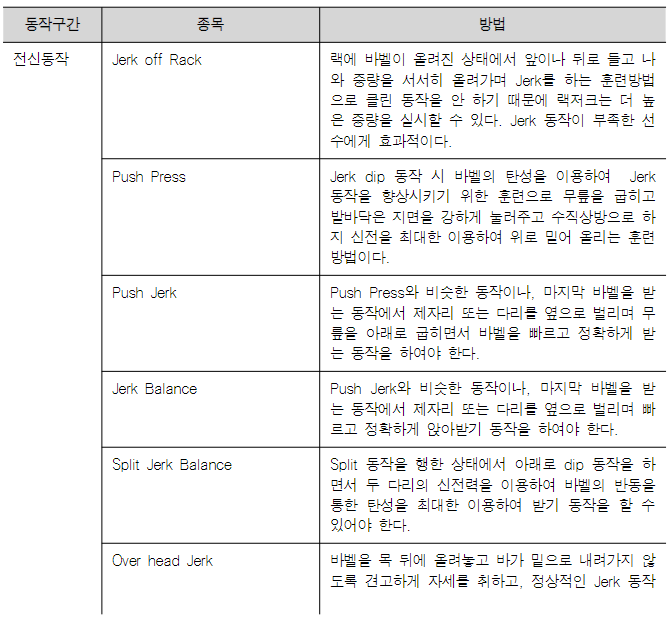

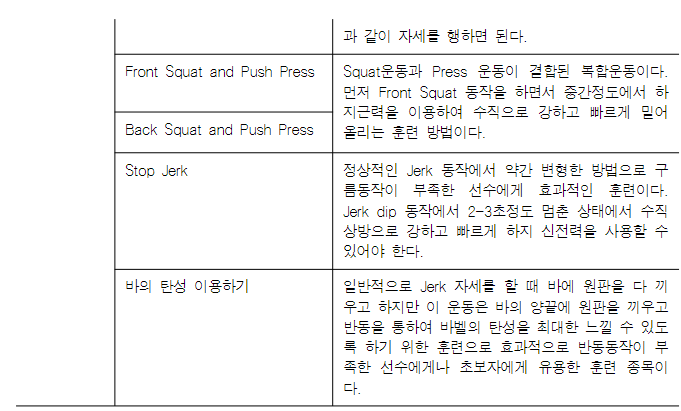



--------------------------------


{'동작구간': '전신동작',
 '종목': [{'방법': '랙에 바벨이 올려진 상태에서 앞이나 뒤로 들고 나와 중량을 서서히 올리기며 Jerk를 하는 훈련방법으로 클린 '
               '동작을 안 하기 때문에 랙저드 더 높은 중량을 실시할 수 있다. Jerk 동작이 부족한 선수에게 효과적이다.',
         '종류': 'Jerk off Rack'},
        {'방법': 'Jerk dip 동작 시 바벨의 탄성을 이용하여 Jerk 동작을 향상시키기 위한 훈련으로 무릎을 굽히고 발바닥은 '
               '지면을 강하게 눌러주고 수직상방으로 하지 신전을 최대한 이용하여 위로 밀어 올리는 훈련 방법이다.',
         '종류': 'Push Press'},
        {'방법': 'Push Press와 비슷한 동작이나, 마지막 바벨을 받는 동작에서 제자리 또는 다리를 옆으로 벌리며 무릎을 '
               '아래로 급히 접어 바벨을 빠르고 정확하게 받는 동작을 하여야 한다.',
         '종류': 'Push Jerk'},
        {'방법': 'Push Jerk와 비슷한 동작이나, 마지막 바벨을 받는 동작에서 제자리 또는 다리를 옆으로 벌리며 빠르고 '
               '정확하게 앉아받기 동작을 하여야 한다.',
         '종류': 'Jerk Balance'},
        {'방법': 'Split 동작을 행한 상태에서 아래로 앉는 동작을 하면서 두 다리의 신전력을 이용하여 바벨의 탄성을 최대한 '
               '이용하여 빠르게 동작을 할 수 있어야 한다.',
         '종류': 'Split Jerk Balance'},
        {'방법': '바벨을 목 뒤에 올려놓고 바가 밑으로 내려가지 않도록 견고하게 자세를 취하고, 정상적인 Jerk 동작과 같이 '
               '자세

AIMessage(content='{\n  "동작구간": "전신동작",\n  "종목": [\n    {\n      "종류": "Jerk off Rack",\n      "방법": "랙에 바벨이 올려진 상태에서 앞이나 뒤로 들고 나와 중량을 서서히 올리기며 Jerk를 하는 훈련방법으로 클린 동작을 안 하기 때문에 랙저드 더 높은 중량을 실시할 수 있다. Jerk 동작이 부족한 선수에게 효과적이다."\n    },\n    {\n      "종류": "Push Press",\n      "방법": "Jerk dip 동작 시 바벨의 탄성을 이용하여 Jerk 동작을 향상시키기 위한 훈련으로 무릎을 굽히고 발바닥은 지면을 강하게 눌러주고 수직상방으로 하지 신전을 최대한 이용하여 위로 밀어 올리는 훈련 방법이다."\n    },\n    {\n      "종류": "Push Jerk",\n      "방법": "Push Press와 비슷한 동작이나, 마지막 바벨을 받는 동작에서 제자리 또는 다리를 옆으로 벌리며 무릎을 아래로 급히 접어 바벨을 빠르고 정확하게 받는 동작을 하여야 한다."\n    },\n    {\n      "종류": "Jerk Balance",\n      "방법": "Push Jerk와 비슷한 동작이나, 마지막 바벨을 받는 동작에서 제자리 또는 다리를 옆으로 벌리며 빠르고 정확하게 앉아받기 동작을 하여야 한다."\n    },\n    {\n      "종류": "Split Jerk Balance",\n      "방법": "Split 동작을 행한 상태에서 아래로 앉는 동작을 하면서 두 다리의 신전력을 이용하여 바벨의 탄성을 최대한 이용하여 빠르게 동작을 할 수 있어야 한다."\n    },\n    {\n      "종류": "Over head Jerk",\n      "방법": "바벨을 목 뒤에 올려놓고 바가 밑으로 내려가지 않도록 견고하게 자세를 취하고, 정상적인 Jerk 동작과 같이 자세를 행하면 된다."\n    },\n    {\n   

In [43]:
draw_image_result(dataset['cutoff_4'], model_name='gpt-4o')

## 전처리 방안

In [9]:
from PIL import Image

def merge_images(image_paths):
    images = [Image.open(img_path) for img_path in image_paths]
    width = min(img.width for img in images)
    images = [img.resize((width, img.height)) for img in images]
    merged = Image.new('RGB', (width, sum(img.height for img in images)))
    y_offset = 0
    for img in images:
        merged.paste(img, (0, y_offset))
        y_offset += img.height
    
    return merged

In [10]:
import io

def merge_images_to_base64(merged_image):
    img_byte_arr = io.BytesIO()
    merged_image.save(img_byte_arr, format='PNG')
    img_byte_arr = img_byte_arr.getvalue()
    
    base64_image = base64.b64encode(img_byte_arr).decode("utf-8")
        
    return base64_image, 'png'

In [22]:
image_list =  [merge_images(dataset[data]) for data in dataset]

In [24]:
def draw_image_result_preprocessed(merge_image, model_name='gpt-4o-mini'):
    prompt = load_prompt('../prompt/information_table/table_cutoff_preprocessed_20250304_01.yaml')
    chat_prompt = ChatPromptTemplate.from_messages(prompt['messages'])
    llm = ChatOpenAI(model=model_name, temperature=0)
    chain = chat_prompt | llm

    base64_image, image_type = merge_images_to_base64(merge_image)

    result = chain.invoke({'image_type': image_type,
                           'base64_image': base64_image,
                           'language': 'KOREAN'})

    display(merge_image)

    print("\n\n--------------------------------\n\n")

    pprint(parse_json_string(result.content))

    print("\n\n--------------------------------\n\n")

    input_token = result.response_metadata['token_usage']['prompt_tokens']
    output_token = result.response_metadata['token_usage']['completion_tokens']

    input_dolor = round(input_token * 0.0001 * 0.15, 5)
    output_dolor = round(output_token * 0.0001 * 0.6, 5)

    input_won = round(input_dolor * 1440)
    output_won = round(output_dolor * 1440)

    print(f"input: {input_token},  {input_dolor}$, {input_won}원")
    print(f"output: {output_token},  {output_dolor}$, {output_won}원")
    return result

### gpt-4o-mini 모델

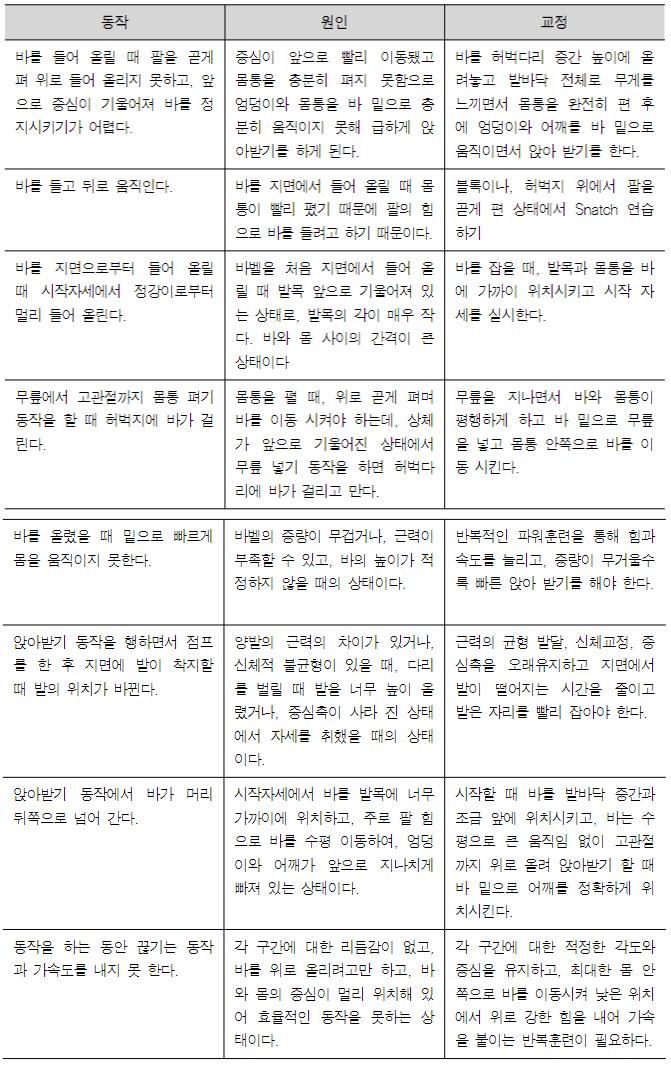



--------------------------------


{'table': [{'교정': '바를 허벅지 중간 높이에 올려놓고 발바닥 전체로 무게를 느끼면서 통증을 완전히 편 후 영양이 억제되지 않게 '
                  '반응한다.',
            '동작': '바를 들어 올릴 때 팔을 굽혀 위로 들어 올리지 않고, 앞으로 중심이 기울어져 바를 정지시키기가 어렵다.',
            '원인': '중심이 앞으로 빨리 이동하고 몸통이 충동적으로 퍼지 못하고 영양이 없는 통증을 막 이로써 몸의 움직임이 '
                  '억제하게 된다.'},
           {'교정': '블록을 허벅지 위에서 팔꿈치 굽게 한 상태에서 Snatch 연습하기.',
            '동작': '바를 들고 뒤로 움직인다.',
            '원인': '바를 지면으로부터 들어 올릴 때 통증이 빨리 느껴지기 때문에 필히 힘으로 바를 들어 올리게 된다.'},
           {'교정': '바를 잡고, 발목과 몸통을 바에 가까이 위치시키고 시작 자세를 실시한다.',
            '동작': '바를 지면으로부터 들어 올릴 때 시작자세에서 정강이로부터 멀리 들어 올린다.',
            '원인': '바벨을 잡는 지면에서 들어 올릴 때 발목 앞쪽이 기울어져 있는 상태로, 발목의 각이 매우 작다. 바벨 등 '
                  '사이의 간격이 큰 상태이다.'},
           {'교정': '무릎을 지나면서 바의 몸통이 평행하게 하고 바 밀로 무릎을 놓는 동작을 한다.',
            '동작': '무릎까지 고관절까지 몸통 펴기 동작을 할 때 허벅지가 바가 걸린다.',
            '원인': '몸통을 펴고, 위로 굽게 펴서 바를 이리 저리 하면서, 상체가 앞으로 기울어진 상태에서 무릎을 놓기 동작을 '
                  '하며 허벅지에 바가 걸리고 만다.'},
  

AIMessage(content='{\n  "table": [\n    {\n      "동작": "바를 들어 올릴 때 팔을 굽혀 위로 들어 올리지 않고, 앞으로 중심이 기울어져 바를 정지시키기가 어렵다.",\n      "원인": "중심이 앞으로 빨리 이동하고 몸통이 충동적으로 퍼지 못하고 영양이 없는 통증을 막 이로써 몸의 움직임이 억제하게 된다.",\n      "교정": "바를 허벅지 중간 높이에 올려놓고 발바닥 전체로 무게를 느끼면서 통증을 완전히 편 후 영양이 억제되지 않게 반응한다."\n    },\n    {\n      "동작": "바를 들고 뒤로 움직인다.",\n      "원인": "바를 지면으로부터 들어 올릴 때 통증이 빨리 느껴지기 때문에 필히 힘으로 바를 들어 올리게 된다.",\n      "교정": "블록을 허벅지 위에서 팔꿈치 굽게 한 상태에서 Snatch 연습하기."\n    },\n    {\n      "동작": "바를 지면으로부터 들어 올릴 때 시작자세에서 정강이로부터 멀리 들어 올린다.",\n      "원인": "바벨을 잡는 지면에서 들어 올릴 때 발목 앞쪽이 기울어져 있는 상태로, 발목의 각이 매우 작다. 바벨 등 사이의 간격이 큰 상태이다.",\n      "교정": "바를 잡고, 발목과 몸통을 바에 가까이 위치시키고 시작 자세를 실시한다."\n    },\n    {\n      "동작": "무릎까지 고관절까지 몸통 펴기 동작을 할 때 허벅지가 바가 걸린다.",\n      "원인": "몸통을 펴고, 위로 굽게 펴서 바를 이리 저리 하면서, 상체가 앞으로 기울어진 상태에서 무릎을 놓기 동작을 하며 허벅지에 바가 걸리고 만다.",\n      "교정": "무릎을 지나면서 바의 몸통이 평행하게 하고 바 밀로 무릎을 놓는 동작을 한다."\n    },\n    {\n      "동작": "바를 올릴 때 밀로 빠르게 몸을 움직이지 못한다.",\n      "원인": "바벨의 중심이 무게가 가벼운 부축할 수 있고, 바의 높이

In [25]:
draw_image_result_preprocessed(image_list[0])

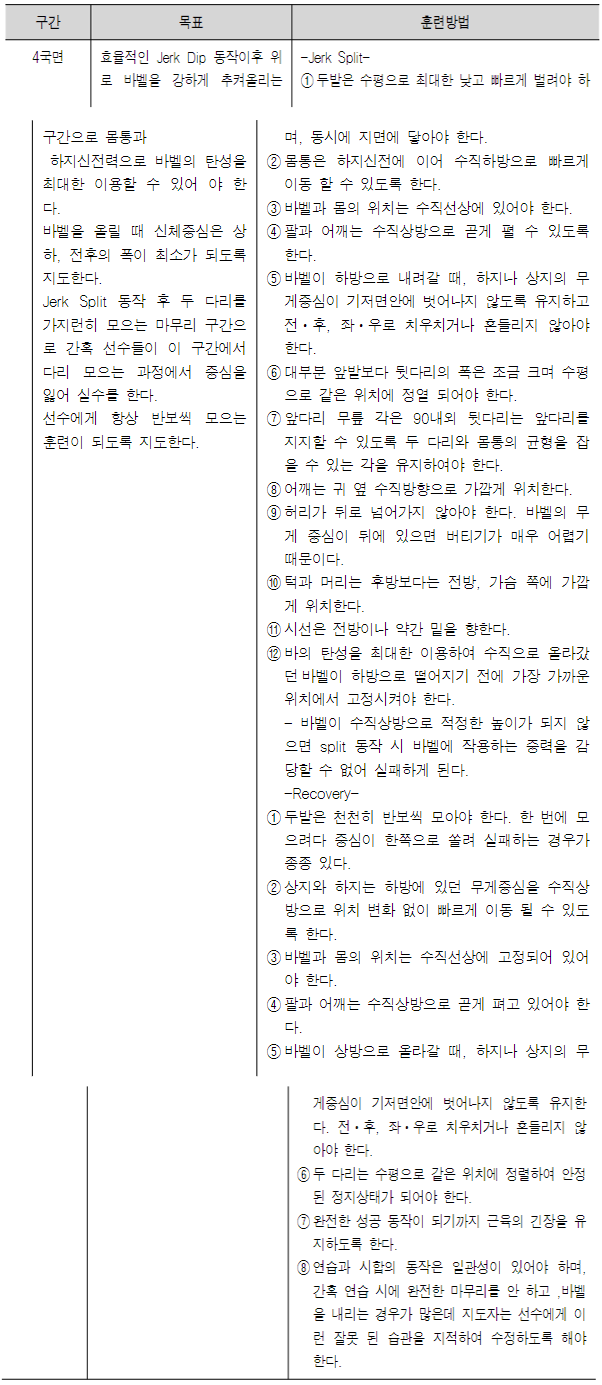



--------------------------------


{'목표': '효율적인 Jerk Dip 동작 이후로 바벨을 강하게 추체올리는 것',
 '주간': '4주간',
 '훈련방법': [{'단계': 1, '설명': '몸, 등시 지면에 닿아야 한다.'},
          {'단계': 2, '설명': '몸을 하체지지에 의하여 수직하방으로 빠르게 이동할 수 있도록 한다.'},
          {'단계': 3, '설명': '바벨의 몸의 위치는 수직선상에 있어야 한다.'},
          {'단계': 4, '설명': '팔과 어깨는 수직상방으로 굳게 펴져 있어야 한다.'},
          {'단계': 5,
           '설명': '바벨이 하방으로 내려갈 때, 하체 상체의 무게중심이 기면에 머물러야 하므로 치우치지 않아야 한다.'},
          {'단계': 6, '설명': '다른 부위는 뒤로 밀리지 않고 고정 금지 상태로 유지되어야 한다.'},
          {'단계': 7, '설명': '어깨는 귀 옆 수직방향으로 가깝게 위치한다.'},
          {'단계': 8,
           '설명': '허리는 뒤로 넘어가지 않아야 한다. 바벨의 무게 중심이 뒤에 있으므로 버티기가 매우 어렵기 때문이다.'},
          {'단계': 9, '설명': '턱과 머리는 후방보다 전방, 가슴 쪽에 위치한다.'},
          {'단계': 10, '설명': '시선은 전방이나 약간 위로 향한다.'},
          {'단계': 11, '설명': '바벨 탄성을 최대한 이용하여 수직으로 올리다.'},
          {'단계': 12, '설명': '바벨이 하방으로 떨어지기 전에 가장 가까운 위치에서 고정수기가 한다.'},
          {'단계': 13,
           '설명': '바벨의 수직상방으로 적합한 동작이 되지 않으면 split 동작 시 바벨에 작용하는 감당할 수 없어 실패하게 '
                 '된다

AIMessage(content='{\n  "주간": "4주간",\n  "목표": "효율적인 Jerk Dip 동작 이후로 바벨을 강하게 추체올리는 것",\n  "훈련방법": [\n    {\n      "단계": 1,\n      "설명": "몸, 등시 지면에 닿아야 한다."\n    },\n    {\n      "단계": 2,\n      "설명": "몸을 하체지지에 의하여 수직하방으로 빠르게 이동할 수 있도록 한다."\n    },\n    {\n      "단계": 3,\n      "설명": "바벨의 몸의 위치는 수직선상에 있어야 한다."\n    },\n    {\n      "단계": 4,\n      "설명": "팔과 어깨는 수직상방으로 굳게 펴져 있어야 한다."\n    },\n    {\n      "단계": 5,\n      "설명": "바벨이 하방으로 내려갈 때, 하체 상체의 무게중심이 기면에 머물러야 하므로 치우치지 않아야 한다."\n    },\n    {\n      "단계": 6,\n      "설명": "다른 부위는 뒤로 밀리지 않고 고정 금지 상태로 유지되어야 한다."\n    },\n    {\n      "단계": 7,\n      "설명": "어깨는 귀 옆 수직방향으로 가깝게 위치한다."\n    },\n    {\n      "단계": 8,\n      "설명": "허리는 뒤로 넘어가지 않아야 한다. 바벨의 무게 중심이 뒤에 있으므로 버티기가 매우 어렵기 때문이다."\n    },\n    {\n      "단계": 9,\n      "설명": "턱과 머리는 후방보다 전방, 가슴 쪽에 위치한다."\n    },\n    {\n      "단계": 10,\n      "설명": "시선은 전방이나 약간 위로 향한다."\n    },\n    {\n      "단계": 11,\n      "설명": "바벨 탄성을 최대한 이용하여 수직으로 올리다."\n    },\n    {\n      "단계": 12,\n      "설명":

In [26]:
draw_image_result_preprocessed(image_list[1])

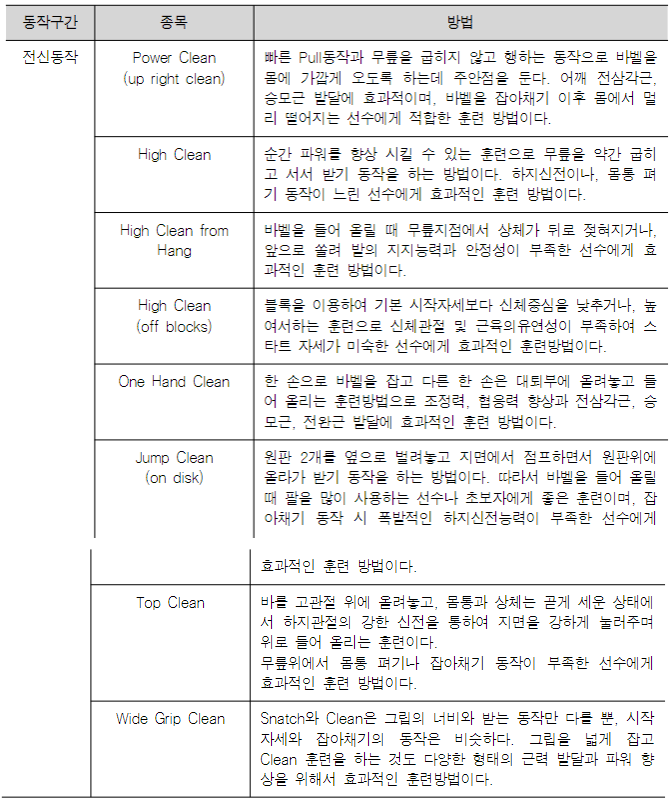



--------------------------------


{'동작구간': [{'방법': '빠른 Pull동작과 무릎을 굽히지 않고 행하는 동작으로 바벨을 몸에 가까이 오도록 하는데 주안점을 둔다. '
                 '어깨 전사각도, 승모근 발달에 효과적이며, 바벨을 잡아체에 밀어 붙여서 멀리 떨어지는 선수에게 적합한 훈련 '
                 '방법이다.',
           '종목': 'Power Clean (up right clean)'},
          {'방법': '순간 파워를 향상 시킬 수 있는 훈련으로 무릎을 약간 굽히고 서서 반기 동작하는 방법이다. 하체신전이, 몸통 '
                 '뒤쪽이 동작이 긴 선수에게 효과적인 훈련 방법이다.',
           '종목': 'High Clean'},
          {'방법': '바벨을 들어 올릴 때 레푸지저에서 상체를 뒤로 젖혀지나, 앞쪽으로 밀어내서 지지력과 안정성을 부각하는 '
                 '선수에게 효과적인 훈련 방법이다.',
           '종목': 'High Clean from Hang'},
          {'방법': '블록을 이용하여 기존 시작자세보다 신체중심을 낮추거나, 높여서는 훈련은 신체균형 및 근육유연성에 부각하여 '
                 '스타트 자세가 미숙한 선수에게 효과적인 훈련방법이다.',
           '종목': 'High Clean (off blocks)'},
          {'방법': '한 손으로 바벨을 잡고 다른 한 손은 대체로 올려놓고 들어 올리는 훈련방법으로 조정력, 힘의 향상과 '
                 '전신각도, 승모근, 전반적인 발달에 효과적인 훈련 방법이다.',
           '종목': 'One Hand Clean'},
          {'방법': '윗몸 2개를 엮어 바벨을 지렛대로 접어들어 원판위에 올리기 위한 동작하는 방법이다. 할 때

AIMessage(content='{\n  "동작구간": [\n    {\n      "종목": "Power Clean (up right clean)",\n      "방법": "빠른 Pull동작과 무릎을 굽히지 않고 행하는 동작으로 바벨을 몸에 가까이 오도록 하는데 주안점을 둔다. 어깨 전사각도, 승모근 발달에 효과적이며, 바벨을 잡아체에 밀어 붙여서 멀리 떨어지는 선수에게 적합한 훈련 방법이다."\n    },\n    {\n      "종목": "High Clean",\n      "방법": "순간 파워를 향상 시킬 수 있는 훈련으로 무릎을 약간 굽히고 서서 반기 동작하는 방법이다. 하체신전이, 몸통 뒤쪽이 동작이 긴 선수에게 효과적인 훈련 방법이다."\n    },\n    {\n      "종목": "High Clean from Hang",\n      "방법": "바벨을 들어 올릴 때 레푸지저에서 상체를 뒤로 젖혀지나, 앞쪽으로 밀어내서 지지력과 안정성을 부각하는 선수에게 효과적인 훈련 방법이다."\n    },\n    {\n      "종목": "High Clean (off blocks)",\n      "방법": "블록을 이용하여 기존 시작자세보다 신체중심을 낮추거나, 높여서는 훈련은 신체균형 및 근육유연성에 부각하여 스타트 자세가 미숙한 선수에게 효과적인 훈련방법이다."\n    },\n    {\n      "종목": "One Hand Clean",\n      "방법": "한 손으로 바벨을 잡고 다른 한 손은 대체로 올려놓고 들어 올리는 훈련방법으로 조정력, 힘의 향상과 전신각도, 승모근, 전반적인 발달에 효과적인 훈련 방법이다."\n    },\n    {\n      "종목": "Jump Clean (on disk)",\n      "방법": "윗몸 2개를 엮어 바벨을 지렛대로 접어들어 원판위에 올리기 위한 동작하는 방법이다. 할 때 팔을 많이 사용하는 선수는 초보자에게 좋은 방법이다."\n    },\n    {\n      "종목"

In [27]:
draw_image_result_preprocessed(image_list[2])

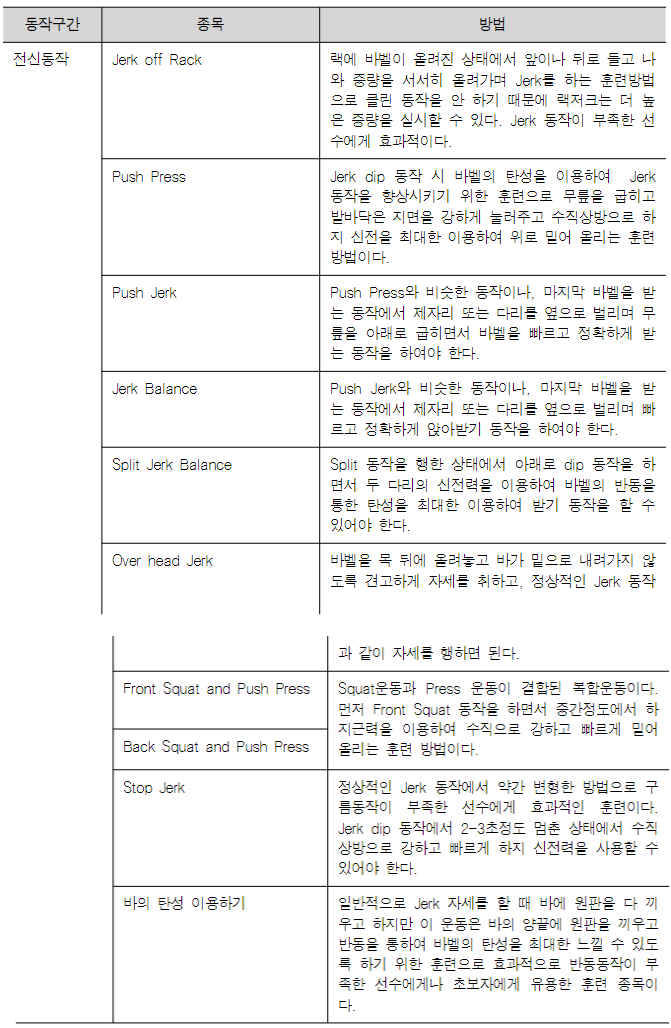



--------------------------------


{'운동구간': [{'방법': '랙에 바벨이 올려진 상태에서 앞이나 뒤로 들고 나와 종목을 서서히 올리며 Jerk를 하는 훈련방법으로 클린 '
                 '동작은 안 하기 때문에 랙에서는 종목을 실시할 수 없다. Jerk 동작의 부착화 선택에 효과적이다.',
           '종목': 'Jerk off Rack'},
          {'방법': 'Jerk dip 동작 시 바벨의 탄성을 이용하여 Jerk 동작을 향상시키기 위한 훈련으로 무릎을 굽히고 '
                 '발바닥은 지면을 강하게 밀고 주상체를 하여 지 신전을 최대한 이용하여 위로 밀어 올리는 훈련 방법이다.',
           '종목': 'Push Press'},
          {'방법': 'Push Press와 비슷한 동작이나, 마지막 바벨을 받는 동작에서 지지리 또는 다리를 엇볼로 벌리며 무릎을 '
                 '아래로 굽히면서 바벨을 정확하게 받는 동작을 하여야 한다.',
           '종목': 'Push Jerk'},
          {'방법': 'Push Jerk와 비슷한 동작이나, 마지막 바벨을 받는 동작에서 지지리 또는 다리를 엇볼로 벌리며 빠르고 '
                 '정확하게 안아받기 동작을 하여야 한다.',
           '종목': 'Jerk Balance'},
          {'방법': 'Split 동작을 행하는 상태에서 아래 dip 동작을 하면서 두 다리의 신전력을 이용하여 바벨의 반동을 통한 '
                 '탄성을 최대한 이용하여 빠르게 동작을 할 수 있어야 한다.',
           '종목': 'Split Jerk Balance'},
          {'방법': '바벨을 목 뒤에 올려놓고 바가 밀리지 않도록 견고하게 자세를 취하고, 정상적인 Jerk 동작을 한다.',
           '

AIMessage(content='{\n  "운동구간": [\n    {\n      "종목": "Jerk off Rack",\n      "방법": "랙에 바벨이 올려진 상태에서 앞이나 뒤로 들고 나와 종목을 서서히 올리며 Jerk를 하는 훈련방법으로 클린 동작은 안 하기 때문에 랙에서는 종목을 실시할 수 없다. Jerk 동작의 부착화 선택에 효과적이다."\n    },\n    {\n      "종목": "Push Press",\n      "방법": "Jerk dip 동작 시 바벨의 탄성을 이용하여 Jerk 동작을 향상시키기 위한 훈련으로 무릎을 굽히고 발바닥은 지면을 강하게 밀고 주상체를 하여 지 신전을 최대한 이용하여 위로 밀어 올리는 훈련 방법이다."\n    },\n    {\n      "종목": "Push Jerk",\n      "방법": "Push Press와 비슷한 동작이나, 마지막 바벨을 받는 동작에서 지지리 또는 다리를 엇볼로 벌리며 무릎을 아래로 굽히면서 바벨을 정확하게 받는 동작을 하여야 한다."\n    },\n    {\n      "종목": "Jerk Balance",\n      "방법": "Push Jerk와 비슷한 동작이나, 마지막 바벨을 받는 동작에서 지지리 또는 다리를 엇볼로 벌리며 빠르고 정확하게 안아받기 동작을 하여야 한다."\n    },\n    {\n      "종목": "Split Jerk Balance",\n      "방법": "Split 동작을 행하는 상태에서 아래 dip 동작을 하면서 두 다리의 신전력을 이용하여 바벨의 반동을 통한 탄성을 최대한 이용하여 빠르게 동작을 할 수 있어야 한다."\n    },\n    {\n      "종목": "Over head Jerk",\n      "방법": "바벨을 목 뒤에 올려놓고 바가 밀리지 않도록 견고하게 자세를 취하고, 정상적인 Jerk 동작을 한다."\n    },\n    {\n      "종목": "Front Squat and Push Press",

In [28]:
draw_image_result_preprocessed(image_list[3])

### gpt-4o 모델

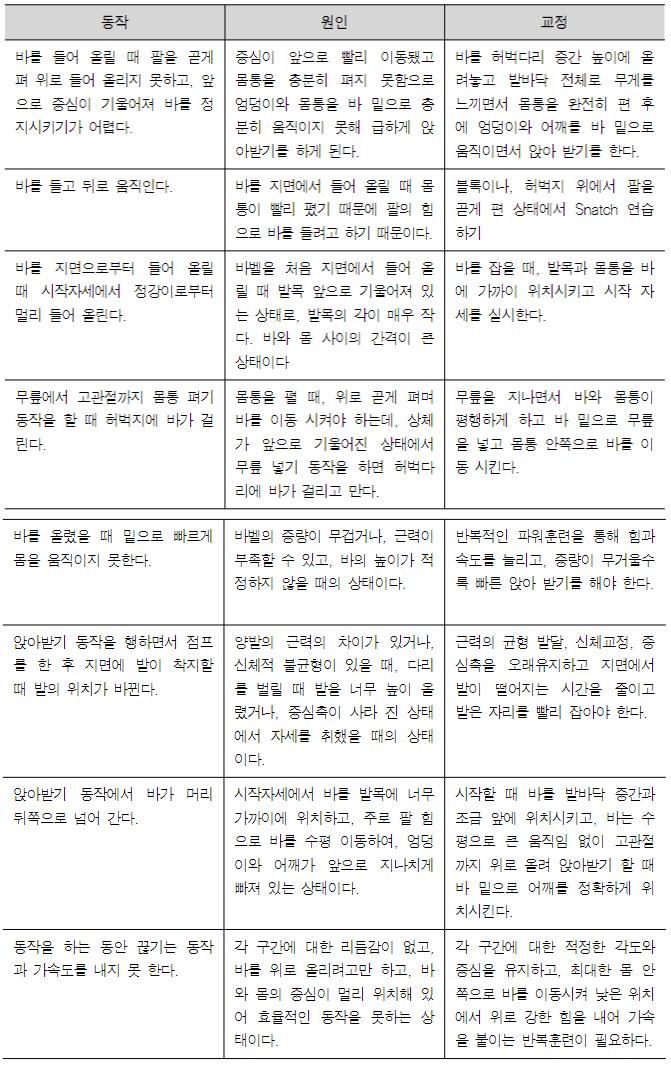



--------------------------------


{'table': [{'교정': '바를 허벅다리 중간 높이에 올려놓고 발바닥 전체로 무게를 느끼면서 몸통을 완전히 편 후에 엉덩이와 어깨를 '
                  '바 밑으로 움직이면서 앉아 받기를 한다.',
            '동작': '바를 들어 올릴 때 팔을 굽게 펴 위로 들어 올리지 못하고, 앞으로 중심이 기울어져 바를 정지시키기가 '
                  '어렵다.',
            '원인': '중심이 앞으로 빨리 이동했고 몸통을 충분히 펴지 못했으므로 엉덩이와 몸통을 바 밑으로 충분히 움직이지 못해 '
                  '급하게 앞아래가 하게 된다.'},
           {'교정': '블록이나, 허벅지 위에서 팔을 굽게 전 상태에서 Snatch 연습하기',
            '동작': '바를 들고 뒤로 움직인다.',
            '원인': '바를 지면에서 들어 올릴 때 몸통이 빨리 펴지기 때문에 팔의 힘으로 바를 들려고 하기 때문이다.'},
           {'교정': '바를 잡을 때, 발목과 몸통을 바에 가까이 위치시키고 시작 자세를 실시한다.',
            '동작': '바를 지면으로부터 들어 올릴 때 시작자세에서 정강이로부터 멀리 들어 올린다.',
            '원인': '바벨을 처음 지면에서 들어 올릴 때 발목 앞으로 기울어져 있는 상태로, 발목의 각이 매우 작다. 바와 몸 '
                  '사이의 간격이 큰 상태이다.'},
           {'교정': '무릎을 지나면서 바의 몸통이 평행하게 하고 바 밑으로 무릎을 넣고 몸통 안쪽으로 바를 이동 시킨다.',
            '동작': '무릎에서 고관절까지 몸통 펴기 동작을 할 때 허벅지에 바가 걸린다.',
            '원인': '몸통을 펴며, 위로 굽게 펴며 바를 이동 시켜야 하는데, 상체가 앞으로 기울어

AIMessage(content='{\n  "table": [\n    {\n      "동작": "바를 들어 올릴 때 팔을 굽게 펴 위로 들어 올리지 못하고, 앞으로 중심이 기울어져 바를 정지시키기가 어렵다.",\n      "원인": "중심이 앞으로 빨리 이동했고 몸통을 충분히 펴지 못했으므로 엉덩이와 몸통을 바 밑으로 충분히 움직이지 못해 급하게 앞아래가 하게 된다.",\n      "교정": "바를 허벅다리 중간 높이에 올려놓고 발바닥 전체로 무게를 느끼면서 몸통을 완전히 편 후에 엉덩이와 어깨를 바 밑으로 움직이면서 앉아 받기를 한다."\n    },\n    {\n      "동작": "바를 들고 뒤로 움직인다.",\n      "원인": "바를 지면에서 들어 올릴 때 몸통이 빨리 펴지기 때문에 팔의 힘으로 바를 들려고 하기 때문이다.",\n      "교정": "블록이나, 허벅지 위에서 팔을 굽게 전 상태에서 Snatch 연습하기"\n    },\n    {\n      "동작": "바를 지면으로부터 들어 올릴 때 시작자세에서 정강이로부터 멀리 들어 올린다.",\n      "원인": "바벨을 처음 지면에서 들어 올릴 때 발목 앞으로 기울어져 있는 상태로, 발목의 각이 매우 작다. 바와 몸 사이의 간격이 큰 상태이다.",\n      "교정": "바를 잡을 때, 발목과 몸통을 바에 가까이 위치시키고 시작 자세를 실시한다."\n    },\n    {\n      "동작": "무릎에서 고관절까지 몸통 펴기 동작을 할 때 허벅지에 바가 걸린다.",\n      "원인": "몸통을 펴며, 위로 굽게 펴며 바를 이동 시켜야 하는데, 상체가 앞으로 기울어진 상태에서 무릎 넣기 동작을 하면 허벅다리에 바가 걸리고 만다.",\n      "교정": "무릎을 지나면서 바의 몸통이 평행하게 하고 바 밑으로 무릎을 넣고 몸통 안쪽으로 바를 이동 시킨다."\n    },\n    {\n      "동작": "바를 혼잡을 때 밑으로 빠르게 몸을 움직이지 못한다.",\n

In [29]:
draw_image_result_preprocessed(image_list[0], model_name='gpt-4o')

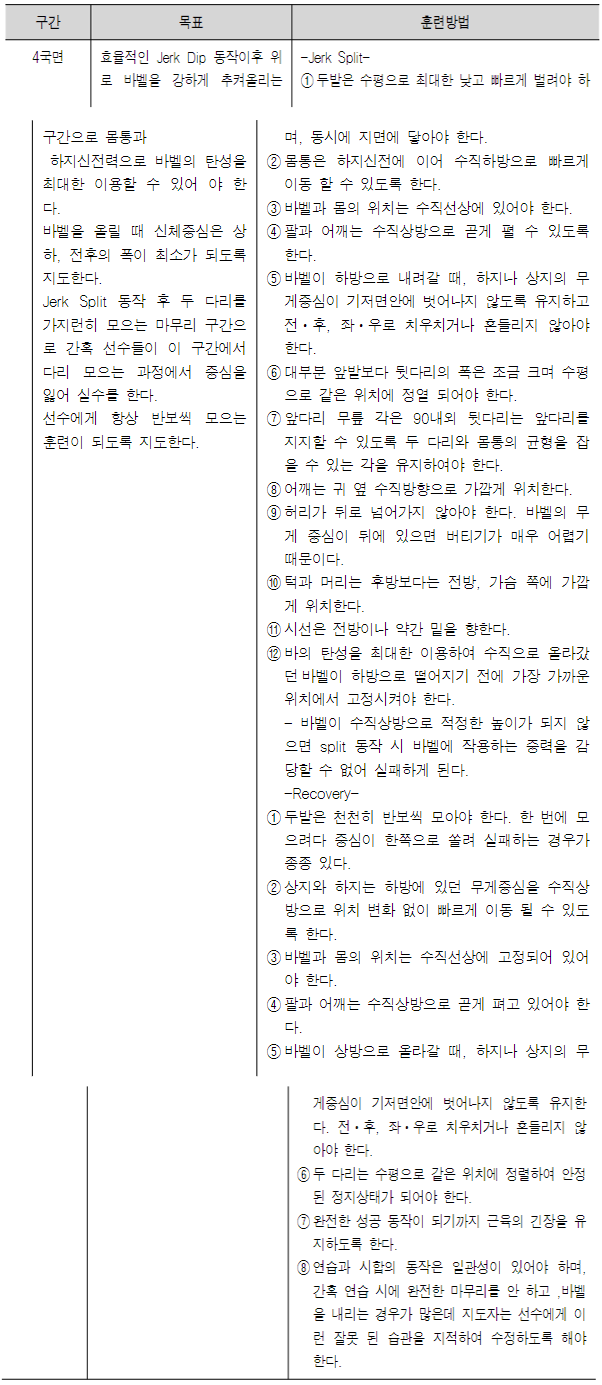



--------------------------------


{'구간': '4구간',
 '목표': '효율적인 Jerk Dip 동작이후 위로 바벨을 강하게 추켜올리는',
 '훈련방법': ['-Jerk Split-',
          '① 두발은 수평으로 최대한 낮고 빠르게 벌려야 하며, 동시에 지면에 닿아야 한다.',
          '② 몸통은 하신전적이며 이어 수직하방으로 빠르게 이동 할 수 있도록 한다.',
          '③ 바벨과 몸의 위치는 수직선상에 있어야 한다.',
          '④ 팔과 어깨는 수직상방으로 크게 펼 수 있도록 한다.',
          '⑤ 바벨이 하방으로 내려갈 때, 하나나 상지의 무게중심이 기저면에 벗어나지 않도록 하며, 전, 후, 좌, 우로 치우치거나 '
          '흔들리지 않아야 한다.',
          '⑥ 대부분 몸통과 뒷다리의 폭은 조금 크며 중심을 오른쪽에 치우치지 않도록 한다.',
          '⑦ 유지할 수 있도록 두 다리와 발등의 균형을 잡을 수 있는 각을 유지하여야 한다.',
          '⑧ 어깨는 귀 옆 수직방향으로 가깝게 위치한다.',
          '⑨ 허리가 뒤로 넘어가지 않아야 한다. 바벨의 무게 중심이 뒤에 있으면 버티기가 매우 어렵기 때문이다.',
          '⑩ 턱과 머리는 후방보다는 전방, 가슴 쪽에 가깝게 위치한다.',
          '⑪ 시선은 전방이나 약간 위를 향한다.',
          '⑫ 바의 탄성을 최대한 이용하여 수직으로 올라간다 바벨이 하방으로 떨어지기 전에 가장 가까운 위치에서 고정시켜야 한다.',
          '- 바벨이 수직상방으로 적정한 높이가 되지 않으면 split 동작 시 바벨에 작용하는 중력을 감당할 수 없어 실패하게 '
          '된다.',
          '-Recovery-',
          '① 두발은 천천히 반복색 모아야 한다. 한 번에 모으려다 중심이 한쪽으로 쏠려 실패하는

AIMessage(content='{\n  "구간": "4구간",\n  "목표": "효율적인 Jerk Dip 동작이후 위로 바벨을 강하게 추켜올리는",\n  "훈련방법": [\n    "-Jerk Split-",\n    "① 두발은 수평으로 최대한 낮고 빠르게 벌려야 하며, 동시에 지면에 닿아야 한다.",\n    "② 몸통은 하신전적이며 이어 수직하방으로 빠르게 이동 할 수 있도록 한다.",\n    "③ 바벨과 몸의 위치는 수직선상에 있어야 한다.",\n    "④ 팔과 어깨는 수직상방으로 크게 펼 수 있도록 한다.",\n    "⑤ 바벨이 하방으로 내려갈 때, 하나나 상지의 무게중심이 기저면에 벗어나지 않도록 하며, 전, 후, 좌, 우로 치우치거나 흔들리지 않아야 한다.",\n    "⑥ 대부분 몸통과 뒷다리의 폭은 조금 크며 중심을 오른쪽에 치우치지 않도록 한다.",\n    "⑦ 유지할 수 있도록 두 다리와 발등의 균형을 잡을 수 있는 각을 유지하여야 한다.",\n    "⑧ 어깨는 귀 옆 수직방향으로 가깝게 위치한다.",\n    "⑨ 허리가 뒤로 넘어가지 않아야 한다. 바벨의 무게 중심이 뒤에 있으면 버티기가 매우 어렵기 때문이다.",\n    "⑩ 턱과 머리는 후방보다는 전방, 가슴 쪽에 가깝게 위치한다.",\n    "⑪ 시선은 전방이나 약간 위를 향한다.",\n    "⑫ 바의 탄성을 최대한 이용하여 수직으로 올라간다 바벨이 하방으로 떨어지기 전에 가장 가까운 위치에서 고정시켜야 한다.",\n    "- 바벨이 수직상방으로 적정한 높이가 되지 않으면 split 동작 시 바벨에 작용하는 중력을 감당할 수 없어 실패하게 된다.",\n    "-Recovery-",\n    "① 두발은 천천히 반복색 모아야 한다. 한 번에 모으려다 중심이 한쪽으로 쏠려 실패하는 경우가 종종 있다.",\n    "② 상지와 하지는 하방에 있던 무게중심을 수직상방으로 위치 변화 없이 빠르게 이동 될 수 있도록 한다.",\n    "③ 바벨과 몸의 위치는 수직선상에 

In [30]:
draw_image_result_preprocessed(image_list[1], model_name='gpt-4o')

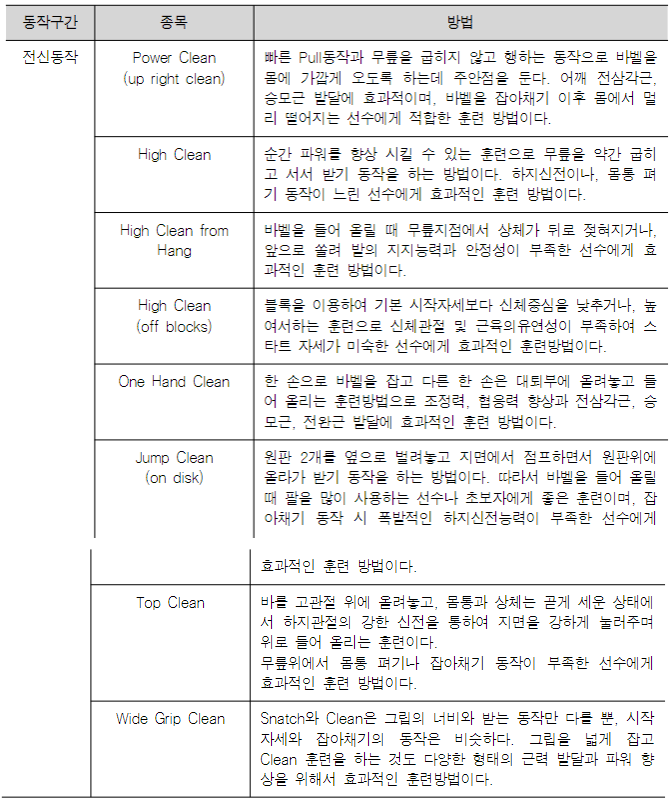



--------------------------------


{'동작구간': '전신동작',
 '종목': [{'방법': '빠른 Pull동작과 무릎을 굽히지 않고 행하는 동작으로 바벨을 몸에 가깝게 오도록 하여 주어짐을 둔다. 어깨 '
               '전상각근, 승모근 발달에 효과적이며, 바벨을 잡아서기 이후 등에 멀리 떨어지는 선수에게 적합한 훈련 방법이다.',
         '이름': 'Power Clean (up right clean)'},
        {'방법': '순간 파워를 항상 시킬 수 있는 훈련으로 무릎을 약간 굽히고 서서 받기 동작을 하는 방법이다. 하지신전이나, '
               '통증 퍼기 동작이 느린 선수에게 효과적인 훈련 방법이다.',
         '이름': 'High Clean'},
        {'방법': '바벨을 들어 올릴 때 쿠루자세에서 상체가 뒤로 젖혀지거나, 앞으로 쏠릴 때 지지능력과 안정성이 부족한 선수에게 '
               '효과적인 훈련 방법이다.',
         '이름': 'High Clean from Hang'},
        {'방법': '블록을 이용하여 기존 시작자세보다 신체중심을 낮추거나, 높여서하는 훈련으로 신체균형 및 근육의 유연성이 부족하여 '
               '스타트 자세가 미숙한 선수에게 효과적인 훈련방법이다.',
         '이름': 'High Clean (off blocks)'},
        {'방법': '한 손으로 바벨을 잡고 다른 한 손은 대퇴부에 올려놓고 들어 올리는 훈련방법으로 조정력, 협응력 향상과 '
               '전상각근, 승모근, 전완근 발달에 효과적인 훈련 방법이다.',
         '이름': 'One Hand Clean'},
        {'방법': '원판 2개를 양옆으로 벌려놓고 지면에서 점프하면서 원판위에 올라가 받기 동작을 하는 훈련이다. 점프를 통해 '
               '들

AIMessage(content='{\n  "동작구간": "전신동작",\n  "종목": [\n    {\n      "이름": "Power Clean (up right clean)",\n      "방법": "빠른 Pull동작과 무릎을 굽히지 않고 행하는 동작으로 바벨을 몸에 가깝게 오도록 하여 주어짐을 둔다. 어깨 전상각근, 승모근 발달에 효과적이며, 바벨을 잡아서기 이후 등에 멀리 떨어지는 선수에게 적합한 훈련 방법이다."\n    },\n    {\n      "이름": "High Clean",\n      "방법": "순간 파워를 항상 시킬 수 있는 훈련으로 무릎을 약간 굽히고 서서 받기 동작을 하는 방법이다. 하지신전이나, 통증 퍼기 동작이 느린 선수에게 효과적인 훈련 방법이다."\n    },\n    {\n      "이름": "High Clean from Hang",\n      "방법": "바벨을 들어 올릴 때 쿠루자세에서 상체가 뒤로 젖혀지거나, 앞으로 쏠릴 때 지지능력과 안정성이 부족한 선수에게 효과적인 훈련 방법이다."\n    },\n    {\n      "이름": "High Clean (off blocks)",\n      "방법": "블록을 이용하여 기존 시작자세보다 신체중심을 낮추거나, 높여서하는 훈련으로 신체균형 및 근육의 유연성이 부족하여 스타트 자세가 미숙한 선수에게 효과적인 훈련방법이다."\n    },\n    {\n      "이름": "One Hand Clean",\n      "방법": "한 손으로 바벨을 잡고 다른 한 손은 대퇴부에 올려놓고 들어 올리는 훈련방법으로 조정력, 협응력 향상과 전상각근, 승모근, 전완근 발달에 효과적인 훈련 방법이다."\n    },\n    {\n      "이름": "Jump Clean (on disk)",\n      "방법": "원판 2개를 양옆으로 벌려놓고 지면에서 점프하면서 원판위에 올라가 받기 동작을 하는 훈련이다. 점프를 통해 들어올릴 때 팔을 많이 사용하는 선수나 초보자

In [31]:
draw_image_result_preprocessed(image_list[2], model_name='gpt-4o')

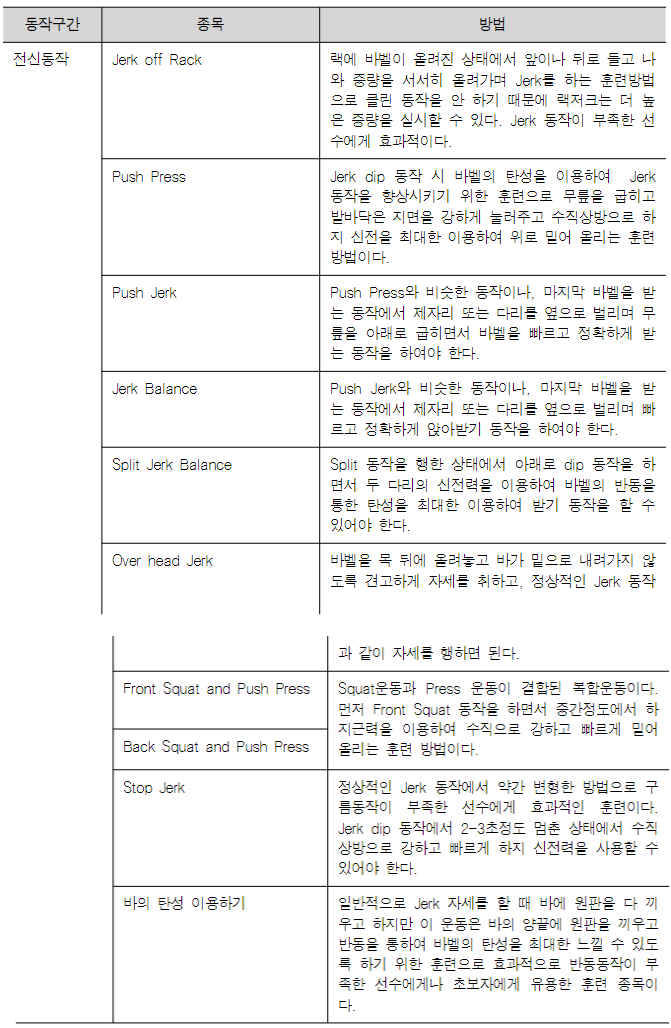



--------------------------------


{'동작구간': '전신동작',
 '종목': [{'방법': '랙에 바벨이 올려진 상태에서 앞이나 뒤로 들고 나와 중량을 서서히 올려가며 Jerk를 하는 훈련방법으로 클린 '
               '동작을 안 하기 때문에 랙에서도 더 높은 중량을 실시할 수 있다. Jerk 동작이 부족한 선수에게 효과적이다.',
         '이름': 'Jerk off Rack'},
        {'방법': 'Jerk dip 동작 시 바벨의 탄성을 이용하여 Jerk 동작을 향상시키기 위한 훈련으로 무릎을 굽히고 발바닥은 '
               '지면을 강하게 딛고 주수상방으로 하지 신전을 최대한 이용하여 위로 밀어 올리는 훈련 방법이다.',
         '이름': 'Push Press'},
        {'방법': 'Push Press와 비슷한 동작이나, 마지막 바벨을 받는 동작에서 제자리 또는 다리를 옆으로 벌리며 무릎을 '
               '아래로 굽히면서 바벨을 빠르고 정확하게 받는 동작을 하여야 한다.',
         '이름': 'Push Jerk'},
        {'방법': 'Push Jerk와 비슷한 동작이나, 마지막 바벨을 받는 동작에서 제자리 또는 다리를 옆으로 벌리며 빠르고 '
               '정확하게 앉아받기 동작을 하여야 한다.',
         '이름': 'Jerk Balance'},
        {'방법': 'Split 동작을 행한 상태에서 아래로 dip 동작을 하면서 두 다리의 신전력을 이용하여 바벨의 반동을 통한 '
               '탄성을 최대한 이용하여 받기 동작을 할 수 있어야 한다.',
         '이름': 'Split Jerk Balance'},
        {'방법': '바벨을 목 뒤에 올려놓고 바가 밑으로 내려가지 않도록 견고하게 자세를 취하고, 정상적인 Jerk 동작',
         '이름': 'O

AIMessage(content='{\n  "동작구간": "전신동작",\n  "종목": [\n    {\n      "이름": "Jerk off Rack",\n      "방법": "랙에 바벨이 올려진 상태에서 앞이나 뒤로 들고 나와 중량을 서서히 올려가며 Jerk를 하는 훈련방법으로 클린 동작을 안 하기 때문에 랙에서도 더 높은 중량을 실시할 수 있다. Jerk 동작이 부족한 선수에게 효과적이다."\n    },\n    {\n      "이름": "Push Press",\n      "방법": "Jerk dip 동작 시 바벨의 탄성을 이용하여 Jerk 동작을 향상시키기 위한 훈련으로 무릎을 굽히고 발바닥은 지면을 강하게 딛고 주수상방으로 하지 신전을 최대한 이용하여 위로 밀어 올리는 훈련 방법이다."\n    },\n    {\n      "이름": "Push Jerk",\n      "방법": "Push Press와 비슷한 동작이나, 마지막 바벨을 받는 동작에서 제자리 또는 다리를 옆으로 벌리며 무릎을 아래로 굽히면서 바벨을 빠르고 정확하게 받는 동작을 하여야 한다."\n    },\n    {\n      "이름": "Jerk Balance",\n      "방법": "Push Jerk와 비슷한 동작이나, 마지막 바벨을 받는 동작에서 제자리 또는 다리를 옆으로 벌리며 빠르고 정확하게 앉아받기 동작을 하여야 한다."\n    },\n    {\n      "이름": "Split Jerk Balance",\n      "방법": "Split 동작을 행한 상태에서 아래로 dip 동작을 하면서 두 다리의 신전력을 이용하여 바벨의 반동을 통한 탄성을 최대한 이용하여 받기 동작을 할 수 있어야 한다."\n    },\n    {\n      "이름": "Over head Jerk",\n      "방법": "바벨을 목 뒤에 올려놓고 바가 밑으로 내려가지 않도록 견고하게 자세를 취하고, 정상적인 Jerk 동작"\n    },\n    {\n      "이름": "F

In [32]:
draw_image_result_preprocessed(image_list[3], model_name='gpt-4o')